# Library Import

In [1]:
#to display all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#import scipy
import struct

from pathlib import Path
from sympy import divisors

from astropy.stats import jackknife_resampling
from astropy.stats import jackknife_stats

from scipy.stats import bootstrap

from scipy.optimize import curve_fit #for the fit

# Input Reading

## reading

In [4]:
#dirName = '../mesons-master/build/dat/'
#name = 'odd_prova26.odd_df2_4fop'
dirName = '../../data_from_scp/'
#name = 'tm_mesons_run3.mesons'
name = 'tm_mesons_run7.mesons'
datName = name + '.dat'

fileName = dirName + datName

In [5]:
plot_base_dir = 'plots/'
plot_dir = 'plot_'+name.split('.')[0]
Path(plot_base_dir+plot_dir).mkdir(parents=True, exist_ok=True)

In [6]:
verbose=True #True to print more output

step = 1 #steps at which configurations are read

early_stop = 0 #number of configurations (counting from the end) not read

In [7]:
#the correlators array will be stored in a dict having as keys the configurations
conf_dict = {}

#list with configurations number
conf_num_list = []

##### reading data from binary dat file #####
with open(fileName, mode='rb') as file: # b is important -> binary
    fileContent = file.read()

    #header is made up of 4 integers, 4x4=16byte
    header_size= 4*4

    #first 16 byte are four 4-byte integers
    ncorr, nnoise, tvals, noise_type = struct.unpack("iiii", fileContent[:header_size])

    #initialization of correlators' variables
    k1=['']*ncorr
    k2=['']*ncorr
    
    mu1=['']*ncorr
    mu2=['']*ncorr

    type1=['']*ncorr
    type2=['']*ncorr
    
    x0=['']*ncorr
    isreal=['']*ncorr

    
    #each correlator has an header of size given by 4x8 + 4x4 = 48byte
    corr_header_size = 4*8 + 4*4
    
    #then there are ncorr block, 8x8 + 4x4 (8 double and 4 int) with the following structure 
    for i in range(ncorr):
         k1[i], k2[i], mu1[i], mu2[i], type1[i], type2[i], x0[i], isreal[i] = struct.unpack("ddddiiii",fileContent[header_size+corr_header_size*i:header_size+corr_header_size*(i+1)])



    #initialization of correlators array
    corr = np.empty(shape=(ncorr,tvals,nnoise),dtype=complex) #correlators
    

    #configuration start right after the header
    first_conf = header_size+corr_header_size*ncorr
    
    #we compute the lenght of the data block for each configuration
    #          sizeof(int) (=confNumber)           ncorr * nnoise * tvals * 2 (re+im) * 8 (sizeof(double))
    conf_len = 4                                 +  nnoise * tvals * (2*ncorr - np.sum(isreal))         * 8         
    #the term with isreal is there because for real correlators only the real part gets stored

    #starting right after the header we read each configuration block
    for start_conf in range(first_conf, len(fileContent)-conf_len*early_stop, conf_len*step):
    #for start_conf in range(first_conf, len(fileContent)-conf_len, conf_len):

        #breaks loop if the file does not contain the whole correlator for the given configuration
        if start_conf+conf_len > len(fileContent) :
            break

        #reading of the configuration number
        conf_number = struct.unpack("i",fileContent[start_conf:start_conf+4])[0]
        if verbose==True:
            print(f"Reading: Gauge Conf = {conf_number}\n")

        #store of conf num
        if conf_number not in conf_num_list:
            conf_num_list.append(conf_number)

        #initialize to 0 the array storing the correlators
        corr.fill(complex(0,0))

        #initialize start reading
        start_reading = start_conf + 4

        #loop over the correlators (ncorr blocks of...)
        for ic in range(ncorr):
            
            #reading of 2 point functions
            for t in range(tvals):
                
                for inoise in range(nnoise):

                    if isreal[ic]==0:
                        #read re and im
                        re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])
                        #store them
                        corr[ic][t][inoise] = complex(re,im)
                        #update start reading
                        start_reading = start_reading+16

                    if isreal[ic]==1:
                        #read re
                        re = struct.unpack("d",fileContent[start_reading:start_reading+8])[0]
                        #store it
                        corr[ic][t][inoise] = complex(re,0.0)
                        #update start reading
                        start_reading = start_reading+8
                        
                    

        #store of correlators associated to the given configuration
        conf_dict[str(conf_number)] = corr.copy()

Reading: Gauge Conf = 1

Reading: Gauge Conf = 2

Reading: Gauge Conf = 3

Reading: Gauge Conf = 4

Reading: Gauge Conf = 5

Reading: Gauge Conf = 6

Reading: Gauge Conf = 7

Reading: Gauge Conf = 8

Reading: Gauge Conf = 9

Reading: Gauge Conf = 10

Reading: Gauge Conf = 11

Reading: Gauge Conf = 12

Reading: Gauge Conf = 13

Reading: Gauge Conf = 14

Reading: Gauge Conf = 15

Reading: Gauge Conf = 16

Reading: Gauge Conf = 17

Reading: Gauge Conf = 18

Reading: Gauge Conf = 19

Reading: Gauge Conf = 20

Reading: Gauge Conf = 21

Reading: Gauge Conf = 22

Reading: Gauge Conf = 23

Reading: Gauge Conf = 24

Reading: Gauge Conf = 25

Reading: Gauge Conf = 26

Reading: Gauge Conf = 27

Reading: Gauge Conf = 28

Reading: Gauge Conf = 29

Reading: Gauge Conf = 30

Reading: Gauge Conf = 31

Reading: Gauge Conf = 32

Reading: Gauge Conf = 33

Reading: Gauge Conf = 34

Reading: Gauge Conf = 35

Reading: Gauge Conf = 36

Reading: Gauge Conf = 37

Reading: Gauge Conf = 38

Reading: Gauge Conf =

In [8]:
#check on correct lenght calculations
(len(fileContent)-header_size-corr_header_size*ncorr)/conf_len

100.0

In [9]:
#construction of array with names and numbers of configurations
conf_names = list(conf_dict.keys())
conf_list = [int(conf) for conf in conf_names ]
nconf = len(conf_list)
nconf

100

In [10]:
#creation of a numpy array with all the correlators
correlators = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)
for iconf,nameconf in enumerate(conf_names):
    correlators[iconf] = conf_dict[nameconf]

In [11]:
if verbose:
    print("(nconf, ncorrelators, tvals, nnoise)")
    print(np.shape(correlators))

(nconf, ncorrelators, tvals, nnoise)
(100, 4, 32, 100)


In [12]:
if verbose:
    for icorr in range(ncorr):
        print(f"k1  = {k1[icorr]}\n")
        print(f"k2  = {k2[icorr]}\n")
        print(f"mu1 = {mu1[icorr]}\n")
        print(f"mu2 = {mu2[icorr]}\n")
        print(f"G1  = {type1[icorr]}\n")
        print(f"G2  = {type2[icorr]}\n")
        print(f"x0  = {x0[icorr]}\n")
        print(f"isr = {isreal[icorr]}\n\n")

k1  = 0.135217

k2  = 0.135217

mu1 = 0.0454

mu2 = 0.0454

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0454

mu2 = -0.0454

G1  = 5

G2  = 5

x0  = 1

isr = 0


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0454

mu2 = 0.0454

G1  = 5

G2  = 5

x0  = 30

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0454

mu2 = -0.0454

G1  = 5

G2  = 5

x0  = 30

isr = 0




In [15]:
corr_x = correlators[:,0,:,:]
#corr_z = correlators[:,1,:,:]
corr_z = correlators[:,3,:,:]

if verbose:
    print("(nconf, tvals, nnoise)")
    print(np.shape(corr_x))
    print(np.shape(corr_z))

(nconf, tvals, nnoise)
(100, 32, 100)
(100, 32, 100)


## Average over Noise

In [16]:
corr_x_navg = corr_x.mean(axis=-1)
corr_z_navg = corr_z.mean(axis=-1)

if verbose:
    print("(nconf, ncorrelators, tvals)")
    print(np.shape(corr_x_navg))
    print(np.shape(corr_z_navg))

(nconf, ncorrelators, tvals)
(100, 32)
(100, 32)


In [17]:
corr_x_navg[0]
corr_x_navg.mean(axis=0)

array([0.00000000e+00+0.j, 6.22621664e+03+0.j, 7.75862652e+02+0.j,
       2.25705001e+02+0.j, 9.39145997e+01+0.j, 5.09728006e+01+0.j,
       3.38562352e+01+0.j, 2.32954795e+01+0.j, 1.66459225e+01+0.j,
       1.16800452e+01+0.j, 7.83437432e+00+0.j, 5.60544959e+00+0.j,
       3.97198486e+00+0.j, 2.86273074e+00+0.j, 2.16496920e+00+0.j,
       1.64866151e+00+0.j, 1.25862205e+00+0.j, 9.71584195e-01+0.j,
       7.93333390e-01+0.j, 7.01418061e-01+0.j, 6.11778165e-01+0.j,
       4.76183524e-01+0.j, 3.59462317e-01+0.j, 2.62959587e-01+0.j,
       1.83172466e-01+0.j, 1.29333364e-01+0.j, 9.62562577e-02+0.j,
       6.91861542e-02+0.j, 5.05468638e-02+0.j, 3.65477947e-02+0.j,
       2.14590461e-02+0.j, 0.00000000e+00+0.j])

array([0.00000000e+00+0.j, 6.21427860e+03+0.j, 7.77324377e+02+0.j,
       2.34144948e+02+0.j, 1.03142493e+02+0.j, 5.77908194e+01+0.j,
       3.70061062e+01+0.j, 2.52480460e+01+0.j, 1.78399228e+01+0.j,
       1.28643434e+01+0.j, 9.44953819e+00+0.j, 7.02998815e+00+0.j,
       5.25695083e+00+0.j, 3.91557930e+00+0.j, 2.90800579e+00+0.j,
       2.16717503e+00+0.j, 1.61706234e+00+0.j, 1.19622699e+00+0.j,
       8.85046847e-01+0.j, 6.55658776e-01+0.j, 4.85637007e-01+0.j,
       3.61688159e-01+0.j, 2.67911902e-01+0.j, 1.98351724e-01+0.j,
       1.46990410e-01+0.j, 1.09452815e-01+0.j, 8.13877495e-02+0.j,
       6.09400393e-02+0.j, 4.58146583e-02+0.j, 3.34012051e-02+0.j,
       1.94748297e-02+0.j, 0.00000000e+00+0.j])

In [18]:
corr_z_navg[0]
corr_z_navg.mean(axis=0)
(corr_z_navg.mean(axis=0).imag/corr_z_navg.mean(axis=0).real)[1:-1]

array([0.00000000e+00+0.00000000e+00j, 8.55284213e-03-4.67647312e-03j,
       1.30127567e-02-7.79976235e-03j, 1.59632414e-02-9.38999267e-03j,
       1.93594482e-02-1.01396157e-02j, 2.45999691e-02-6.72508543e-03j,
       3.32173452e-02-2.78738248e-03j, 4.35520170e-02+5.73881993e-03j,
       5.47313241e-02+1.89117255e-02j, 6.69365421e-02+4.09323335e-02j,
       7.21907122e-02+6.18119494e-02j, 8.26617652e-02+8.41879945e-02j,
       8.00775861e-02+7.46507162e-02j, 5.67123120e-02+2.77732742e-02j,
       2.92973601e-02-6.41782603e-02j, 2.47570280e-02-1.79897441e-01j,
       7.45949491e-02-3.09134717e-01j, 2.07485023e-01-4.05364618e-01j,
       3.76080571e-01-6.78126540e-01j, 2.78771310e-01-1.42295671e+00j,
       4.89415259e-01-1.81440090e+00j, 1.31888652e+00-1.30916773e+00j,
       2.90446261e+00-1.20811019e-01j, 5.95899880e+00+1.68825677e+00j,
       1.20670850e+01+4.38646088e+00j, 2.24528509e+01+7.56853344e+00j,
       4.24051925e+01+1.07110981e+01j, 8.39594187e+01+1.01434918e+01j,
      

array([0.00000000e+00+0.j        , 8.89298539e-03-0.00089179j,
       1.46266864e-02-0.00157969j, 1.85939074e-02-0.00230838j,
       2.24488021e-02-0.00367174j, 2.64136505e-02-0.00534644j,
       3.08419589e-02-0.00701401j, 3.55116984e-02-0.0083j    ,
       4.13986511e-02-0.00946585j, 4.86672539e-02-0.01120921j,
       5.71198426e-02-0.01428051j, 6.78660203e-02-0.01608655j,
       8.14510201e-02-0.01760965j, 9.99471752e-02-0.01828635j,
       1.27245796e-01-0.02077299j, 1.77245768e-01-0.03057561j,
       2.60961742e-01-0.04140025j, 3.90522157e-01-0.05116677j,
       5.99917276e-01-0.04970503j, 9.63488099e-01-0.06884518j,
       1.58560065e+00-0.05928659j, 2.63512388e+00-0.02108916j,
       4.37172723e+00+0.00660667j, 7.32042611e+00+0.02657069j,
       1.25073636e+01-0.01987871j, 2.21039528e+01-0.0284548j ,
       4.10379669e+01-0.09523713j, 8.44343907e+01-0.17709439j,
       2.13830722e+02-0.46325027j, 7.55827275e+02-0.43596548j,
       6.19619639e+03-0.07477341j, 0.00000000e+00+0.j  

/tmp/ipykernel_5742/1785415807.py:3: RuntimeWarning: invalid value encountered in divide
  (corr_z_navg.mean(axis=0).imag/corr_z_navg.mean(axis=0).real)[1:-1]


array([-1.00280433e-01, -1.08000405e-01, -1.24147118e-01, -1.63560588e-01,
       -2.02411893e-01, -2.27417809e-01, -2.33725804e-01, -2.28651114e-01,
       -2.30323374e-01, -2.50009672e-01, -2.37033928e-01, -2.16199211e-01,
       -1.82960114e-01, -1.63250904e-01, -1.72504018e-01, -1.58644911e-01,
       -1.31021439e-01, -8.28531459e-02, -7.14541008e-02, -3.73906205e-02,
       -8.00310151e-03,  1.51122689e-03,  3.62966413e-03, -1.58936063e-03,
       -1.28731711e-03, -2.32070769e-03, -2.09742011e-03, -2.16643457e-03,
       -5.76805696e-04, -1.20676304e-05])

## Preliminary plots and analysis

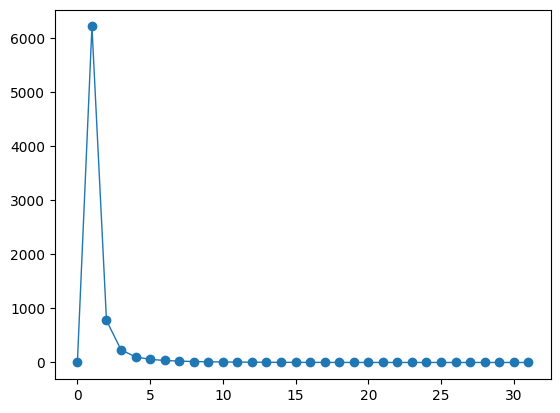

In [19]:
times = np.arange(tvals)

plt.plot(times,np.mean(corr_x_navg,axis=0).real, '-o',linewidth = 1)

Text(0.5, 1.0, 'cut = 3')

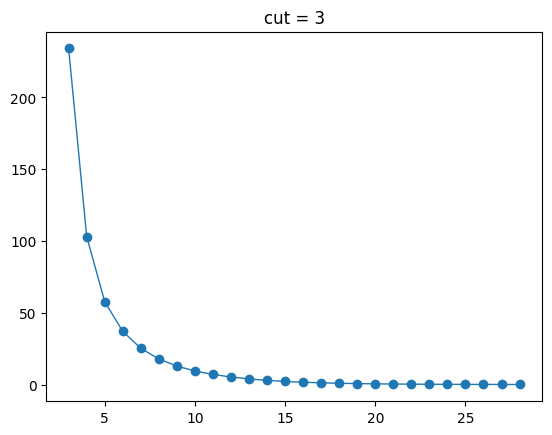

In [20]:
cut = 3
plt.title(f"cut = {cut}")
#plt.yscale('log')
plt.plot(times[cut:-cut],np.mean(corr_x_navg,axis=0).real[cut:-cut], '-o',linewidth = 1)

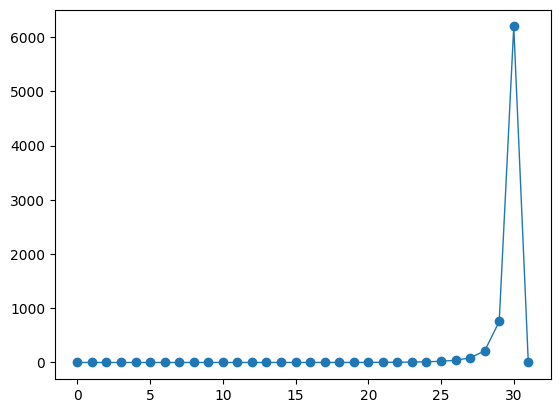

In [21]:
times = np.arange(tvals)

plt.plot(times,np.mean(corr_z_navg,axis=0).real, '-o',linewidth = 1)                     

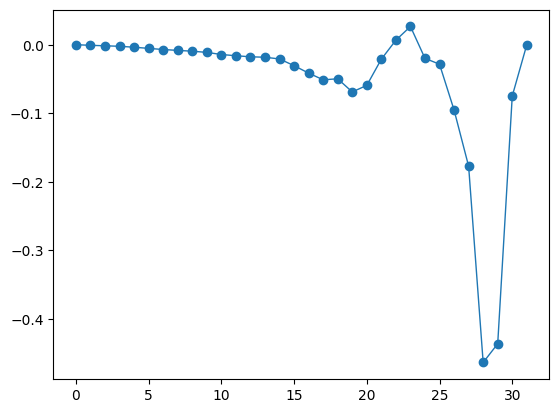

In [22]:
times = np.arange(tvals)

plt.plot(times,np.mean(corr_z_navg,axis=0).imag, '-o',linewidth = 1) 

Text(0.5, 1.0, 'cut = 3')

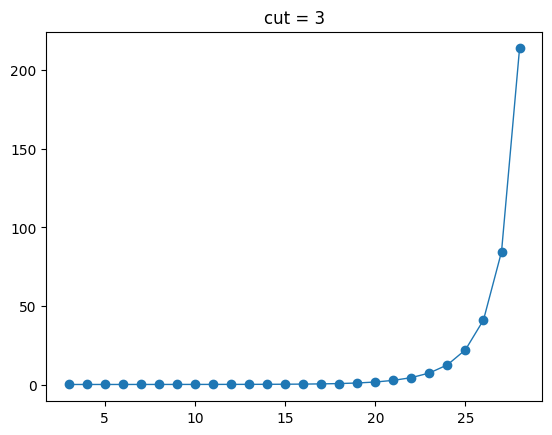

In [23]:
cut = 3
plt.title(f"cut = {cut}")
#plt.yscale('log')
plt.plot(times[cut:-cut],np.mean(corr_z_navg,axis=0).real[cut:-cut], '-o',linewidth = 1)

# Mass fit

In [28]:
eff_mass_x = np.empty(shape=(nconf,tvals-1))
eff_mass_z = np.empty(shape=(nconf,tvals-1))

for iconf in range(nconf):
    eff_mass_x[iconf,:] = np.array([np.log(corr_x_navg[iconf,i].real/corr_x_navg[iconf,i+1].real) for i in range(tvals-1)])
    eff_mass_z[iconf,:] = np.array([np.log(corr_z_navg[iconf,i+1].real/corr_z_navg[iconf,i].real) for i in range(tvals-1)])

if verbose:
    print("(nconf,tvals-1)")
    print(np.shape(eff_mass_x))
    print(np.shape(eff_mass_z))

(nconf,tvals-1)
(100, 31)
(100, 31)


/tmp/ipykernel_5742/3147590764.py:5: RuntimeWarning: divide by zero encountered in log
  eff_mass_x[iconf,:] = np.array([np.log(corr_x_navg[iconf,i].real/corr_x_navg[iconf,i+1].real) for i in range(tvals-1)])
/tmp/ipykernel_5742/3147590764.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  eff_mass_x[iconf,:] = np.array([np.log(corr_x_navg[iconf,i].real/corr_x_navg[iconf,i+1].real) for i in range(tvals-1)])
/tmp/ipykernel_5742/3147590764.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  eff_mass_z[iconf,:] = np.array([np.log(corr_z_navg[iconf,i+1].real/corr_z_navg[iconf,i].real) for i in range(tvals-1)])
/tmp/ipykernel_5742/3147590764.py:6: RuntimeWarning: divide by zero encountered in log
  eff_mass_z[iconf,:] = np.array([np.log(corr_z_navg[iconf,i+1].real/corr_z_navg[iconf,i].real) for i in range(tvals-1)])
/tmp/ipykernel_5742/3147590764.py:6: RuntimeWarning: invalid value encountered in log
  eff_mass_z[iconf,:] = np.array([np.log(corr_z_navg[iconf

In [46]:
eff_mass_z = np.nan_to_num(eff_mass_z,nan=0) # there are some nan in the array!!!

eff_mass_z.mean(axis=0)

/home/tag-e/università/Magistrale/tesi/codice/myCode/python_analysis/my_env/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


array([       inf, 0.49317182, 0.23644793, 0.18134908, 0.13785585,
       0.12861935, 0.11775906, 0.12325134, 0.11729769, 0.09231131,
       0.11953998, 0.17747488, 0.24641819, 0.25400765, 0.36901126,
       0.34872113, 0.35420348, 0.32705122, 0.41450144, 0.5308148 ,
       0.55347442, 0.52848134, 0.51904778, 0.56032486, 0.5771288 ,
       0.62295608, 0.72348133, 0.93017552, 1.26296081, 2.10394084,
             -inf])

## Some plots

<Figure size 640x480 with 0 Axes>

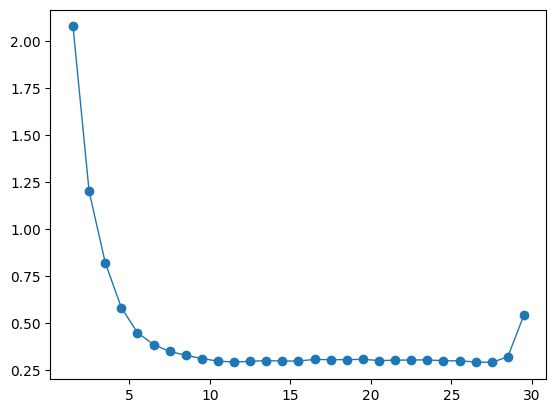

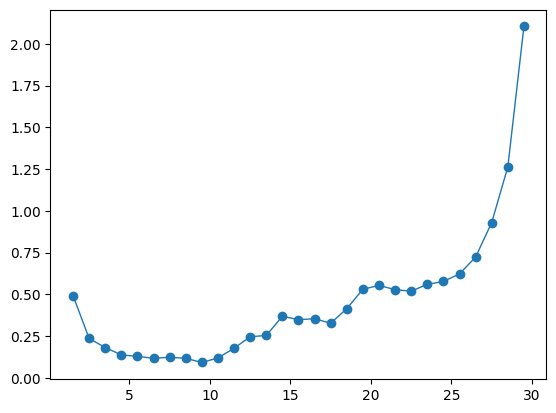

In [47]:
times = np.arange(0,tvals)
eff_mass_times = times[:-1]+0.5

plt.plot(eff_mass_times,np.mean(eff_mass_x,axis=0),'-o',linewidth=1)

plt.figure()
plt.plot(eff_mass_times,np.mean(eff_mass_z,axis=0),'-o',linewidth=1)

Text(0.5, 1.0, 'cut = 5')

<Figure size 640x480 with 0 Axes>

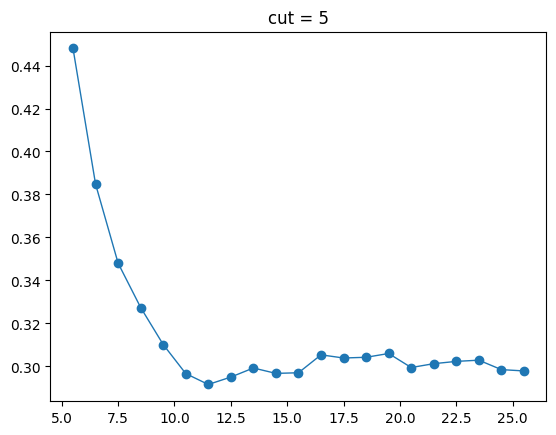

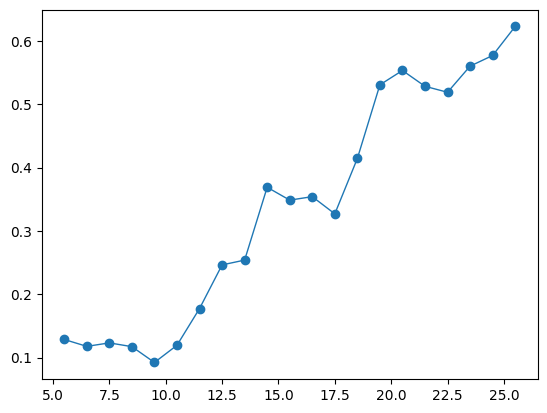

In [48]:
times = np.arange(0,tvals)
eff_mass_times = times[:-1]+0.5

cut = 5

plt.title(f"cut = {cut}")

plt.plot(eff_mass_times[cut:-cut],np.mean(eff_mass_x,axis=0)[cut:-cut],'-o',linewidth=1)

plt.figure()
plt.plot(eff_mass_times[cut:-cut],np.mean(eff_mass_z,axis=0)[cut:-cut],'-o',linewidth=1)

Text(0.5, 1.0, 'cut = 8')

<Figure size 640x480 with 0 Axes>

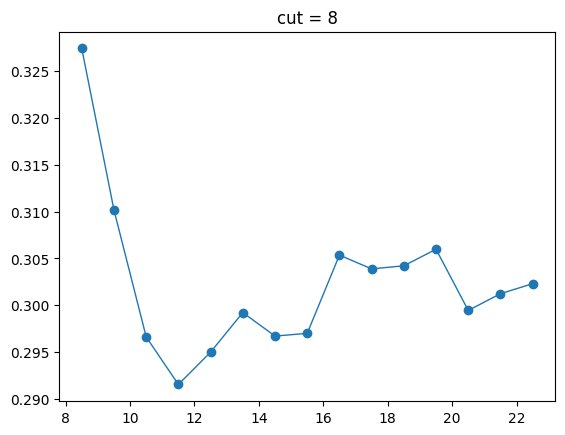

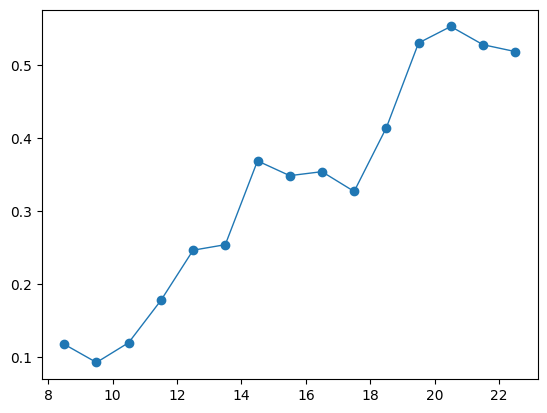

In [49]:
times = np.arange(0,tvals)
eff_mass_times = times[:-1]+0.5

cut = 8

plt.title(f"cut = {cut}")

plt.plot(eff_mass_times[cut:-cut],np.mean(eff_mass_x,axis=0)[cut:-cut],'-o',linewidth=1)

plt.figure()
plt.plot(eff_mass_times[cut:-cut],np.mean(eff_mass_z,axis=0)[cut:-cut],'-o',linewidth=1)

## Mass estimate

In [50]:
cut = 8

eff_mass_x_aver = np.mean( eff_mass_x[:,cut:-cut] , axis=1 )
eff_mass_z_aver = np.mean( eff_mass_z[:,cut:-cut] , axis=1 )

if verbose:
    print("(nconf,)")
    print(np.shape(eff_mass_x_aver))
    print(np.shape(eff_mass_z_aver))

(nconf,)
(100,)
(100,)


In [51]:
#using the jackknife
data = eff_mass_x_aver

test_statistic = np.mean
            
estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)
            
print(estimate,bias,stderr,conf_interval)


data = eff_mass_z_aver

test_statistic = np.mean
            
estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)
            
print(estimate,bias,stderr,conf_interval)

0.30241145751612075 0.0 0.0021061139889979267 [0.29828355 0.30653937]
0.33015710545618104 5.495603971894525e-15 0.009768709517670515 [0.31101079 0.34930342]


## mass estimate with jack

In [52]:
times = np.arange(0,tvals)
eff_mass_times = times[:-1]+0.5

test_statistic = np.mean

eff_mass_x_jack = []
eff_mass_x_jack_std = []
eff_mass_z_jack = []
eff_mass_z_jack_std = []

for t in range(tvals-1):

    data = eff_mass_x[:,t]

    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    eff_mass_x_jack.append(estimate)
    eff_mass_x_jack_std.append(stderr)

    data = eff_mass_z[:,t]

    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    eff_mass_z_jack.append(estimate)
    eff_mass_z_jack_std.append(stderr)

eff_mass_x_jack = np.array(eff_mass_x_jack)
eff_mass_x_jack_std = np.array(eff_mass_x_jack_std)
eff_mass_z_jack = np.array(eff_mass_z_jack)
eff_mass_z_jack_std = np.array(eff_mass_z_jack_std)

/home/tag-e/università/Magistrale/tesi/codice/myCode/python_analysis/my_env/lib/python3.10/site-packages/astropy/stats/jackknife.py:163: RuntimeWarning: invalid value encountered in scalar subtract
  bias = (n - 1) * (mean_jack_stat - stat_data)
/home/tag-e/università/Magistrale/tesi/codice/myCode/python_analysis/my_env/lib/python3.10/site-packages/astropy/stats/jackknife.py:168: RuntimeWarning: invalid value encountered in subtract
  * np.mean((jack_stat - mean_jack_stat) * (jack_stat - mean_jack_stat), axis=0)


In [53]:
eff_mass_x_jack_std/eff_mass_x_jack

array([       nan, 0.00046642, 0.0019114 , 0.00441903, 0.0068578 ,
       0.01044254, 0.01107173, 0.01132923, 0.01404745, 0.01677118,
       0.01762718, 0.02049854, 0.01958846, 0.02059753, 0.02260049,
       0.02266827, 0.01893108, 0.0191097 , 0.02307559, 0.02073719,
       0.01966058, 0.01865085, 0.02218408, 0.0229637 , 0.02169987,
       0.01954692, 0.02223156, 0.02076778, 0.01331241, 0.00628817,
              nan])

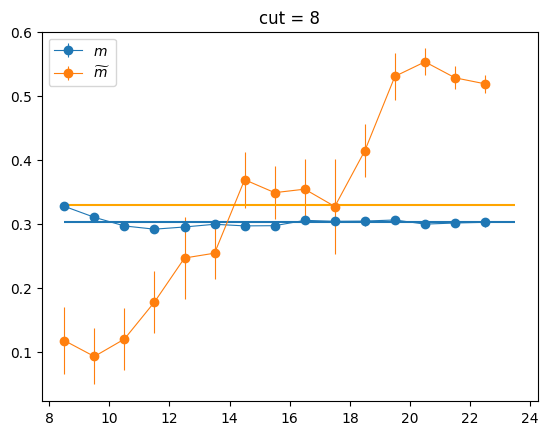

In [54]:
cut = 8
_ = plt.title(f"cut = {cut}")
_ = plt.errorbar(eff_mass_times[cut:-cut],eff_mass_x_jack[cut:-cut],yerr=eff_mass_x_jack_std[cut:-cut],marker='o',linewidth = 0.8,label=r'$m$')
_ = plt.errorbar(eff_mass_times[cut:-cut],eff_mass_z_jack[cut:-cut],yerr=eff_mass_z_jack_std[cut:-cut],marker='o',linewidth = 0.8,label=r'$\widetilde{m}$')
_ = plt.legend()


m_from_jack = np.mean(eff_mass_x_jack[cut:-cut])
mt_from_jack = np.mean(eff_mass_z_jack[cut:-cut])


_ = plt.hlines(m_from_jack,eff_mass_times[cut],eff_mass_times[-cut])
_ = plt.hlines(mt_from_jack,eff_mass_times[cut],eff_mass_times[-cut],color='orange')


In [55]:
print(f"m  = {m_from_jack}")
print(f"mt = {mt_from_jack}")

m  = 0.3024114575161211
mt = 0.3301571054561881


## Mass sinh Fit

### Jackknife

In [56]:
test_statistic = np.mean

corr_x_navg_jack = np.empty(shape=(tvals),dtype=float)
corr_x_navg_jack_std = np.empty(shape=(tvals),dtype=float)
corr_z_navg_jack = np.empty(shape=(tvals),dtype=float)
corr_z_navg_jack_std = np.empty(shape=(tvals),dtype=float)


for t in range(tvals):

    data = corr_x_navg[:,t].real

    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    corr_x_navg_jack[t] = estimate
    corr_x_navg_jack_std[t] = stderr

    if np.abs(bias/estimate)>10**-10:
        print(f"x / {t} / {bias}")



    data = corr_z_navg[:,t].real

    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    corr_z_navg_jack[t] = estimate
    corr_z_navg_jack_std[t] = stderr

    if np.abs(bias/estimate)>10**-10:
        print(f"z / {t} / {bias}")

/tmp/ipykernel_5742/3051873958.py:18: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(bias/estimate)>10**-10:
/tmp/ipykernel_5742/3051873958.py:30: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(bias/estimate)>10**-10:


<ErrorbarContainer object of 3 artists>

<Figure size 640x480 with 0 Axes>

<ErrorbarContainer object of 3 artists>

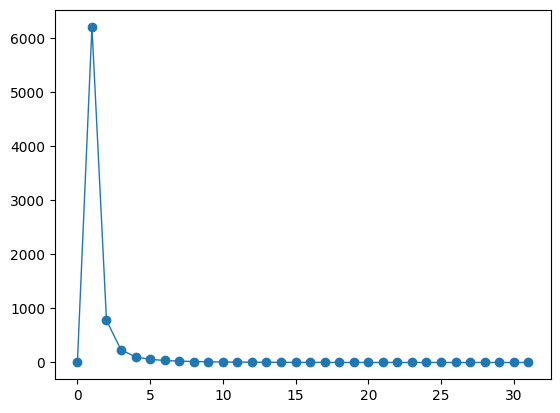

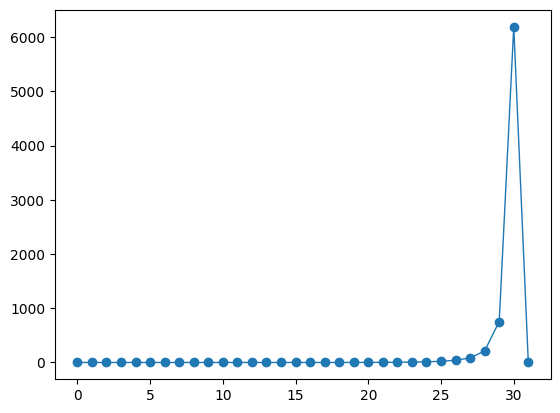

In [57]:
times = np.arange(tvals)

plt.errorbar(times,corr_x_navg_jack,yerr=corr_x_navg_jack_std,marker='o',linewidth=1)

plt.figure()

plt.errorbar(times,corr_z_navg_jack,yerr=corr_z_navg_jack_std,marker='o',linewidth=1)

Text(0.5, 1.0, 'cut = 8')

<ErrorbarContainer object of 3 artists>

<Figure size 640x480 with 0 Axes>

<ErrorbarContainer object of 3 artists>

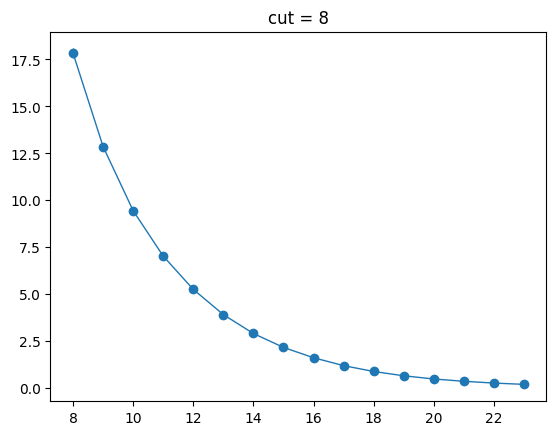

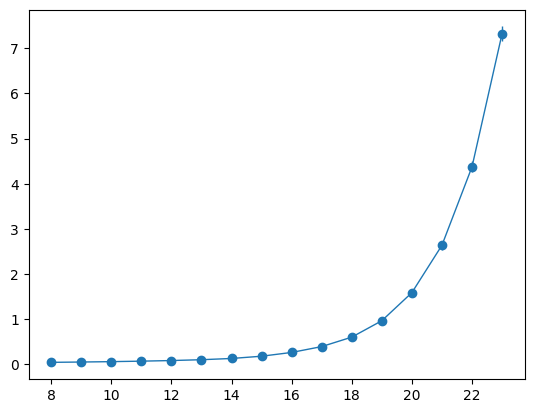

In [58]:
times = np.arange(tvals)

cut = 8

plt.title(f"cut = {cut}")

plt.errorbar(times[cut:-cut],corr_x_navg_jack[cut:-cut],yerr=corr_x_navg_jack_std[cut:-cut],marker='o',linewidth=1)

plt.figure()

plt.errorbar(times[cut:-cut],corr_z_navg_jack[cut:-cut],yerr=corr_z_navg_jack_std[cut:-cut],marker='o',linewidth=1)

### fit with scipy

In [59]:
def chi2(result,data,data_std):
    return np.sum( ((result-data)/data_std)**2 )

In [60]:
guess_mass_x = 0.42
guess_amp_x =  corr_x_navg_jack[4]

def fit_sinh_x(t,amp,mass):
    return amp*np.sinh(mass*(tvals-1-t)) #tvals-1 because T=tvals-1


guess_mass_z = 0.42
guess_amp_z =  corr_x_navg_jack[-4]

def fit_sinh_z(t,amp,mass):
    return amp*np.sinh(mass*t)

In [61]:
#cut  = 12
cut = 8

fit_times_x = times[cut:-cut]
fit_times_z = times[cut:-cut]

fit_data_x = corr_x_navg_jack[cut:-cut]
fit_data_z = corr_z_navg_jack[cut:-cut]

guess_x = [guess_amp_x,guess_mass_x]
guess_z = [guess_amp_z,guess_mass_z]

In [62]:
popt_x,pcov_x = curve_fit(fit_sinh_x, fit_times_x, fit_data_x, p0=guess_x)
perr_x = np.sqrt(np.diag(pcov_x))
fit_result_x = fit_sinh_x(fit_times_x,*popt_x)

popt_z,pcov_z = curve_fit(fit_sinh_z, fit_times_z, fit_data_z, p0=guess_z)
perr_z = np.sqrt(np.diag(pcov_z))
fit_result_z = fit_sinh_z(fit_times_z,*popt_z)

In [63]:
print("Result x:")
print(f"amp:  {popt_x[0]} +- {perr_x[0]}")
print(f"mass: {popt_x[1]} +- {perr_x[1]}\n")

print("Result z:")
print(f"amp:  {popt_z[0]} +- {perr_z[0]}")
print(f"mass: {popt_z[1]} +- {perr_z[1]}\n")

Result x:
amp:  0.03213089406025607 +- 0.0014999167707513727
mass: 0.3044650858061974 +- 0.0021346823151392014

Result z:
amp:  0.00013129876228433842 +- 1.433613400733788e-05
mass: 0.5051544072899292 +- 0.004864112524922389



chi2: 49.85577949168905


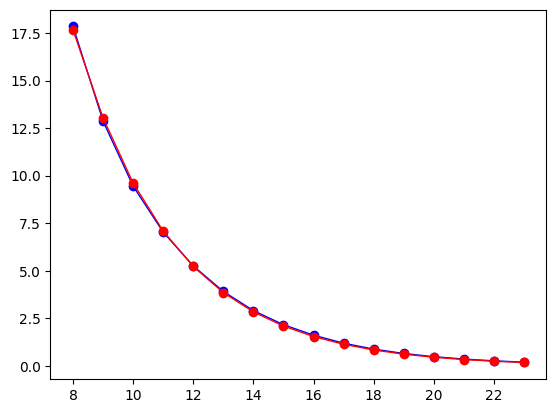

In [64]:
plt.plot(fit_times_x,fit_data_x,'-o',label='data',color='blue',linewidth=1)
plt.plot(fit_times_x,fit_result_x,'-o',label='fit',color='red',linewidth=1)

print(f"chi2: {chi2(fit_result_x,fit_data_x,corr_x_navg_jack_std[cut:-cut])}")

chi2: 583.3166419482924


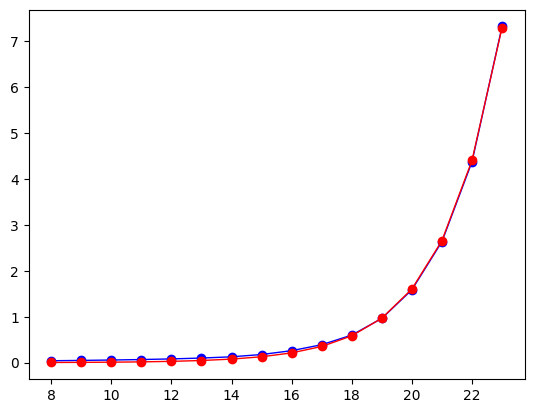

In [65]:
plt.plot(fit_times_z,fit_data_z,'-o',label='data',color='blue',linewidth=1)
plt.plot(fit_times_z,fit_result_z,'-o',label='fit',color='red',linewidth=1)

print(f"chi2: {chi2(fit_result_z,fit_data_z,corr_z_navg_jack_std[cut:-cut])}")

## Intermediate results

In [66]:
mps = popt_x[1]
mps_err = perr_x[1]

mpst = popt_z[1]
mpst_err = perr_z[1]

print(f"m_ps       = {round(mps,5)} +- {round(mps_err,5)}")
print(f"m_ps_tilda = {round(mpst,5)} +- {round(mpst_err,5)}")

m_ps       = 0.30447 +- 0.00213
m_ps_tilda = 0.50515 +- 0.00486


# 3 point func study

## reading

In [67]:
dirName = '../../data_from_scp/'
name = 'odd_run18.odd_df2_4fop'
datName = name + '.dat'

fileName = dirName + datName

In [68]:
noperators=5 #number of operators (VA - AV - SP - PS - TT~)

verbose=True #True to print more output

step = 1 #steps at which configurations are read

early_stop = 0

In [69]:
#the correlators array will be stored in a dict having as keys the configurations
conf_dict = {}
conf_dict_2p = {}

#list with configurations number
conf_num_list = []

##### reading data from binary dat file #####
with open(fileName, mode='rb') as file: # b is important -> binary
    fileContent = file.read()

    #header is made up of 5 integers, 5x4=20byte, and 2 double, 2x8=16byte
    header_size= 6*4 +2*8

    #first 16 byte are four 4-byte integers
    ncorr, nnoise, tvals, noise_type, check_gauge_inv, random_conf, csw, cf = struct.unpack("iiiiiidd", fileContent[:header_size])

    #initialization of correlators' variables
    k1=['']*ncorr
    k2=['']*ncorr
    k3=['']*ncorr
    k4=['']*ncorr
    mu1=['']*ncorr
    mu2=['']*ncorr
    mu3=['']*ncorr
    mu4=['']*ncorr
    typeA=['']*ncorr
    typeB=['']*ncorr
    x0=['']*ncorr
    z0=['']*ncorr

    
    #each correlator has an header of size given by 8x8 + 4x4 = 80byte
    corr_header_size = 8*8 + 4*4
    
    #then there are ncorr block, 8x8 + 4x4 (8 double and 4 int) with the following structure 
    for i in range(ncorr):
         k1[i], k2[i], k3[i], k4[i], mu1[i], mu2[i], mu3[i], mu4[i], typeA[i], typeB[i], x0[i], z0[i] = struct.unpack("ddddddddiiii",fileContent[header_size+corr_header_size*i:header_size+corr_header_size*(i+1)])



    #initialization of correlators array
    conn_corr = np.empty(shape=(ncorr,noperators,tvals,nnoise,nnoise),dtype=complex) #connected correlators
    disc_corr = np.empty(shape=(ncorr,noperators,tvals,nnoise,nnoise),dtype=complex) #disconnected correlators

    x_corr = np.empty(shape=(ncorr,tvals,nnoise),dtype=complex)
    z_corr = np.empty(shape=(ncorr,tvals,nnoise),dtype=complex)


    #offset due to 3 points (see comment below)
    offset_3point = nnoise    *   nnoise   *  tvals                  * noperators        * 2                                    * 2         * 8 
    offset_2point = nnoise * tvals * 2                   * 2         * 8

    offset_diag3 = nnoise    *   nnoise   *  tvals                  * noperators        * 2         * 8
    offset_diag2 = nnoise * tvals                   * 2         * 8

    #configuration start right after the header
    first_conf = header_size+corr_header_size*ncorr
    
    #we compute the lenght of the data block for each configuration
    #          nnoise_A  *  nnoise_B  *  time lenght of lattice * noperators   * ncorrelators * 2 (diagrams=connected+disconnected)  * 2 (re+im) * 8 (sizeof(double))  + sizeof(int) (= conf_number)
    conf_len = nnoise    *   nnoise   *  tvals                  * noperators   * ncorr        * 2                                    * 2         * 8                    + 4
    #                     ncorr * nnoise * tvaks * 2 (x+z 2point corr) * 2 (re+im) * 8 (sizeof(double))
    conf_len = conf_len + ncorr * nnoise * tvals * 2                   * 2         * 8

    #starting right after the header we read each configuration block
    for start_conf in range(first_conf, len(fileContent)-conf_len*early_stop, conf_len*step):
    #for start_conf in range(first_conf, len(fileContent)-conf_len, conf_len):

        #breaks loop if the file does not contain the whole correlator for the given configuration
        if start_conf+conf_len > len(fileContent) :
            break

        #reading of the configuration number
        conf_number = struct.unpack("i",fileContent[start_conf:start_conf+4])[0]
        if verbose==True:
            print(f"Reading: Gauge Conf = {conf_number}\n")

        #store of conf num
        if conf_number not in conf_num_list:
            conf_num_list.append(conf_number)

        #initialize to 0 the array storing the correlators
        conn_corr.fill(complex(0,0))
        disc_corr.fill(complex(0,0))
        #same for 2 point
        x_corr.fill(complex(0,0))
        z_corr.fill(complex(0,0))

        start_reading = start_conf+4

        #loop over the correlators (ncorr blocks of...)
        for ic in range(ncorr):

            #reading of chunk with conn corr
            
            #loop over the operators (...noperators blocs of...)
            for op in range(noperators):
                #loop over time values (...tvals blocks of...)
                for t in range(tvals):
                    #loop over noiseB vectors (...nnoise blocks of...)
                    for noiseB in range(nnoise):
                        #loop over noiseA vectors (...nnoise blocks of...)
                        for noiseA in range(nnoise):
                    
                            #reading of re and im part of correlators   (...complex numbers)
                            
                            #connected correlators

                            #begin of reading point (8=sizeof(double)) (last 2 is number of diagrams)
                            #start_reading = start_conf+4 + 2*8*noiseA+2*8*nnoise*(noiseB+nnoise*(t+tvals*(op+noperators*2*ic)))
                            
                            #reading of real and complex for connected corr
                            re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])

                            #store complex number
                            conn_corr[ic][op][t][noiseB][noiseA] = complex(re,im)


                            #disconnected correlators

                            #begin of reading point (8=sizeof(double)) (last 2 is number of diagrams)
                            #start_reading = start_conf+4 + 2*8*noiseA+2*8*nnoise*(noiseB+nnoise*(t+tvals*(op+noperators*(2*ic+1))))

                            #reading of real and complex for connected corr
                            #re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])
                            re,im = struct.unpack("dd",fileContent[start_reading+offset_diag3:start_reading+offset_diag3+16])

                            #store complex number
                            disc_corr[ic][op][t][noiseB][noiseA] = complex(re,im)

                            #update start reading
                            start_reading = start_reading+16

                            ############# new reading #########

                            #start_reading  = start_conf + 4 + 2 * 2*8 * (noiseA + nnoise*(noiseB + nnoise*(t + tvals*(op + noperators*ic ) ) ) )

                            #re_con, im_con, re_disc, im_disc = struct.unpack("dddd",fileContent[start_reading:start_reading+2*2*8])
                            #conn_corr[ic,op,t,noiseB,noiseA] = complex(re_con,im_con)
                            #disc_corr[ic,op,t,noiseB,noiseA] = complex(re_disc,im_disc)

            #update start reading for the disconnected part
            start_reading = start_reading + offset_diag3
            
            if(ic==0):
                print(start_reading+16)
            
            #reading of 2 point functions
            for t in range(tvals):
                for inoise in range(nnoise):
                    #start_reading = start_conf + 4 + offset_3point + 2*8*(inoise+nnoise*(t+tvals*2*ic)) #last 2 is for 2point in x and z
                    re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])
                    x_corr[ic][t][inoise] = complex(re,im)
                    #start_reading = start_conf + 4 + offset_3point + 2*8*(inoise+nnoise*(t+tvals*(2*ic+1))) 
                    re,im = struct.unpack("dd",fileContent[start_reading+offset_diag2:start_reading+offset_diag2+16])
                    z_corr[ic][t][inoise] = complex(re,im)

                    #update start reading
                    start_reading = start_reading+16
            #update start reading for the 2point with source in z
            start_reading = start_reading + offset_diag2

        #store of correlators associated to the given configuration
        if str(conf_number) not in conf_dict.keys():
            conf_dict[str(conf_number)] = (conn_corr.copy(),disc_corr.copy())
            conf_dict_2p[str(conf_number)] = (x_corr.copy(),z_corr.copy())
        else:
            conf_dict[str(conf_number)+"_GaugeInvCheck"] = (conn_corr.copy(),disc_corr.copy())
            conf_dict_2p[str(conf_number)+"_GaugeInvCheck"] = (x_corr.copy(),z_corr.copy())

Reading: Gauge Conf = 1

1152140
Reading: Gauge Conf = 2

2319504
Reading: Gauge Conf = 3

3486868
Reading: Gauge Conf = 4

4654232
Reading: Gauge Conf = 5

5821596
Reading: Gauge Conf = 6

6988960
Reading: Gauge Conf = 7

8156324
Reading: Gauge Conf = 8

9323688
Reading: Gauge Conf = 9

10491052
Reading: Gauge Conf = 10

11658416
Reading: Gauge Conf = 11

12825780
Reading: Gauge Conf = 12

13993144
Reading: Gauge Conf = 13

15160508
Reading: Gauge Conf = 14

16327872
Reading: Gauge Conf = 15

17495236
Reading: Gauge Conf = 16

18662600
Reading: Gauge Conf = 17

19829964
Reading: Gauge Conf = 18

20997328
Reading: Gauge Conf = 19

22164692
Reading: Gauge Conf = 20

23332056
Reading: Gauge Conf = 21

24499420
Reading: Gauge Conf = 22

25666784
Reading: Gauge Conf = 23

26834148
Reading: Gauge Conf = 24

28001512
Reading: Gauge Conf = 25

29168876
Reading: Gauge Conf = 26

30336240
Reading: Gauge Conf = 27

31503604
Reading: Gauge Conf = 28

32670968
Reading: Gauge Conf = 29

33838332
Re

In [70]:
#check on correct lenght calculations
(len(fileContent)-header_size-corr_header_size*ncorr)/(offset_3point+offset_2point+4)

991.0

In [71]:
#construction of array with names and numbers of configurations
conf_names = list(conf_dict.keys())[0::1+check_gauge_inv]
conf_list = [int(conf) for conf in conf_names ]
nconf = len(conf_list)

In [72]:
#creation of a numpy array with all the correlators
all_correlators = np.empty(shape=(nconf,2,ncorr,noperators,tvals,nnoise,nnoise),dtype=complex) #2 is for connected and disconnected
for iconf,nameconf in enumerate(conf_names):
    all_correlators[iconf] = conf_dict[nameconf]

In [73]:
if verbose:
    print("(nconf, pieces, ncorrelators, noperators, tvals, nnoise, nnoise)")
    print(np.shape(all_correlators))

(nconf, pieces, ncorrelators, noperators, tvals, nnoise, nnoise)
(991, 2, 1, 5, 32, 15, 15)


In [74]:
#analogous for 2 points func
all_2point_x = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)
all_2point_z = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)
for iconf,nameconf in enumerate(conf_names):
    all_2point_x[iconf] = conf_dict_2p[nameconf][0]
    all_2point_z[iconf] = conf_dict_2p[nameconf][1]


if verbose:
    print("(nconf, ncorrelators, tvals, nnoise)")
    print(np.shape(all_2point_x))
    print(np.shape(all_2point_z))

(nconf, ncorrelators, tvals, nnoise)
(991, 1, 32, 15)
(991, 1, 32, 15)


## data to be used

In [91]:
#for the 2 points
#corr_x_navg
#corr_z_navg

nconf = np.shape(corr_x_navg)[0]

corr_3p = all_correlators[:nconf,0,0,:,:,:,:] + all_correlators[:nconf,1,0,:,:,:,:]
corr_3p_navg = corr_3p.mean(axis=-1).mean(axis=-1)


if verbose:
    print("(nconf',tvals)")
    print(np.shape(corr_x_navg))
    print(np.shape(corr_z_navg))
    print("(nconf,noperators,tvals)")
    print(np.shape(corr_3p_navg))

(nconf',tvals)
(100, 32)
(100, 32)
(nconf,noperators,tvals)
(100, 5, 32)


In [92]:
#jackknife
test_statistic = np.mean

corr_x_navg_jack = np.empty(shape=(tvals),dtype=float)
corr_x_navg_jack_std = np.empty(shape=(tvals),dtype=float)
corr_z_navg_jack = np.empty(shape=(tvals),dtype=float)
corr_z_navg_jack_std = np.empty(shape=(tvals),dtype=float)
corr_3p_navg_jack = np.empty(shape=(noperators,tvals),dtype=float)
corr_3p_navg_jack_std = np.empty(shape=(noperators,tvals),dtype=float)


for t in range(tvals):

    data = corr_x_navg[:,t].real

    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    corr_x_navg_jack[t] = estimate
    corr_x_navg_jack_std[t] = stderr

    if np.abs(bias/estimate)>10**-10:
        print(f"x / {t} / {bias}")



    data = corr_z_navg[:,t].real

    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    corr_z_navg_jack[t] = estimate
    corr_z_navg_jack_std[t] = stderr

    if np.abs(bias/estimate)>10**-10:
        print(f"z / {t} / {bias}")

    for iop in range(noperators):

        data = corr_3p_navg[:,iop,t].imag

        estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

        corr_3p_navg_jack[iop,t] = estimate
        corr_3p_navg_jack_std[iop,t] = stderr

        if np.abs(bias/estimate)>10**-10:
            print(f"3p / {iop} / {t} / {bias}")



if verbose:
    print("(tvals)")
    print(np.shape(corr_x_navg_jack))
    print(np.shape(corr_z_navg_jack))
    print("(noperators,tvals)")
    print(np.shape(corr_3p_navg_jack))

(tvals)
(32,)
(32,)
(noperators,tvals)
(5, 32)


/tmp/ipykernel_5742/851436603.py:21: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(bias/estimate)>10**-10:
/tmp/ipykernel_5742/851436603.py:33: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(bias/estimate)>10**-10:
/tmp/ipykernel_5742/851436603.py:45: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(bias/estimate)>10**-10:


## amplitude extraction (hopefully)

In [93]:
#def final_func(t,m,m_tilda):
 #   return 2 * np.exp(-(m+m_tilda)) * ( np.cosh((m+m_tilda)*t) - np.cosh((m-m_tilda)*t) )

In [94]:
'''
element1 = np.empty(shape=(noperators,tvals),dtype=float)
element2 = np.empty(shape=(noperators,tvals),dtype=float)
result = np.empty(shape=(noperators,tvals),dtype=float)
mat_ele_squared = np.empty(shape=(noperators,tvals),dtype=float)
mat_ele = np.empty(shape=(noperators,tvals),dtype=float)

func_factor = np.empty(shape=(tvals),dtype=float)
func_factor = final_func(times,mps,mpst)


for iop in range(noperators):

    element1[iop,:] = corr_3p_navg_jack[iop,:]/corr_z_navg_jack[:]

    element2[iop,:] = corr_3p_navg_jack[iop,::-1]/corr_x_navg_jack[::-1]

    #result[iop,:] = element1[iop,:] * np.conjugate(element2[iop,:])
    result[iop,:] = element1[iop,:] * (-element2[iop,:]) #since the three point is fully imaginary conjugation equals a minus overall

    mat_ele_squared[iop,:] = result[iop,:] * func_factor[:]

    mat_ele[iop,:]  = np.sqrt(mat_ele_squared[iop,:] )
'''

'\nelement1 = np.empty(shape=(noperators,tvals),dtype=float)\nelement2 = np.empty(shape=(noperators,tvals),dtype=float)\nresult = np.empty(shape=(noperators,tvals),dtype=float)\nmat_ele_squared = np.empty(shape=(noperators,tvals),dtype=float)\nmat_ele = np.empty(shape=(noperators,tvals),dtype=float)\n\nfunc_factor = np.empty(shape=(tvals),dtype=float)\nfunc_factor = final_func(times,mps,mpst)\n\n\nfor iop in range(noperators):\n\n    element1[iop,:] = corr_3p_navg_jack[iop,:]/corr_z_navg_jack[:]\n\n    element2[iop,:] = corr_3p_navg_jack[iop,::-1]/corr_x_navg_jack[::-1]\n\n    #result[iop,:] = element1[iop,:] * np.conjugate(element2[iop,:])\n    result[iop,:] = element1[iop,:] * (-element2[iop,:]) #since the three point is fully imaginary conjugation equals a minus overall\n\n    mat_ele_squared[iop,:] = result[iop,:] * func_factor[:]\n\n    mat_ele[iop,:]  = np.sqrt(mat_ele_squared[iop,:] )\n'

In [95]:
mat_ele = np.empty(shape=(noperators,tvals),dtype=float)

for iop in range(noperators):
    for t in range(tvals):
        e1 = corr_3p_navg_jack[iop,t]/corr_z_navg_jack[1]
        e2 = corr_3p_navg_jack[iop,tvals-1-t]/corr_x_navg_jack[tvals-2]
        mat_ele[iop,t] = np.sqrt( e1* e2 )
        #mat_ele[iop,t] = np.sqrt(  e1* (-e2) * final_func(t,mps,mpst) ) 

In [96]:
mat_ele

array([[0.        , 0.03952597, 0.0178755 , 0.01293181, 0.01064857,
        0.00974937, 0.00928766, 0.0090079 , 0.00894428, 0.00897554,
        0.00903073, 0.00915639, 0.00932124, 0.00948114, 0.00939675,
        0.00946728, 0.00946728, 0.00939675, 0.00948114, 0.00932124,
        0.00915639, 0.00903073, 0.00897554, 0.00894428, 0.0090079 ,
        0.00928766, 0.00974937, 0.01064857, 0.01293181, 0.0178755 ,
        0.03952597, 0.        ],
       [0.        , 0.04193847, 0.0093236 , 0.00893397, 0.00766385,
        0.0070833 , 0.00682796, 0.00662806, 0.00655984, 0.00655175,
        0.00652367, 0.00661182, 0.00672645, 0.00682206, 0.00687615,
        0.00692081, 0.00692081, 0.00687615, 0.00682206, 0.00672645,
        0.00661182, 0.00652367, 0.00655175, 0.00655984, 0.00662806,
        0.00682796, 0.0070833 , 0.00766385, 0.00893397, 0.0093236 ,
        0.04193847, 0.        ],
       [0.        , 0.1463542 , 0.08061521, 0.06726765, 0.06228569,
        0.06229713, 0.0657806 , 0.064517  , 0.0638

In [97]:
'''
#alternative with tvals-1
element1 = np.empty(shape=(noperators,tvals-1),dtype=float)
element2 = np.empty(shape=(noperators,tvals-1),dtype=float)
result = np.empty(shape=(noperators,tvals-1),dtype=float)
mat_ele_squared = np.empty(shape=(noperators,tvals-1),dtype=float)
mat_ele = np.empty(shape=(noperators,tvals-1),dtype=float)

func_factor = np.empty(shape=(tvals-1),dtype=float)
func_factor = final_func(times,mps,mpst)


for iop in range(noperators):

    element1[iop,:] = corr_3p_navg_jack[iop,:-1]/corr_z_navg_jack[:-1]

    element2[iop,:] = corr_3p_navg_jack[iop,-2::-1]/corr_x_navg_jack[-2::-1]

    result[iop,:] = element1[iop,:] * np.conjugate(element2[iop,:])

    mat_ele_squared[iop,:] = -result[iop,:] * func_factor[:-1]

    mat_ele[iop,:]  = np.sqrt(mat_ele_squared[iop,:] )
    '''

'\n#alternative with tvals-1\nelement1 = np.empty(shape=(noperators,tvals-1),dtype=float)\nelement2 = np.empty(shape=(noperators,tvals-1),dtype=float)\nresult = np.empty(shape=(noperators,tvals-1),dtype=float)\nmat_ele_squared = np.empty(shape=(noperators,tvals-1),dtype=float)\nmat_ele = np.empty(shape=(noperators,tvals-1),dtype=float)\n\nfunc_factor = np.empty(shape=(tvals-1),dtype=float)\nfunc_factor = final_func(times,mps,mpst)\n\n\nfor iop in range(noperators):\n\n    element1[iop,:] = corr_3p_navg_jack[iop,:-1]/corr_z_navg_jack[:-1]\n\n    element2[iop,:] = corr_3p_navg_jack[iop,-2::-1]/corr_x_navg_jack[-2::-1]\n\n    result[iop,:] = element1[iop,:] * np.conjugate(element2[iop,:])\n\n    mat_ele_squared[iop,:] = -result[iop,:] * func_factor[:-1]\n\n    mat_ele[iop,:]  = np.sqrt(mat_ele_squared[iop,:] )\n    '

In [98]:
#mat_ele_squared

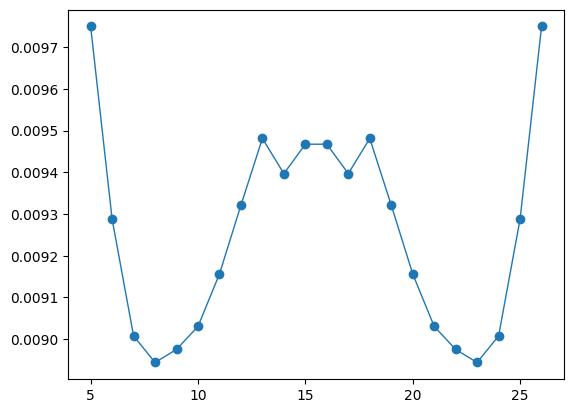

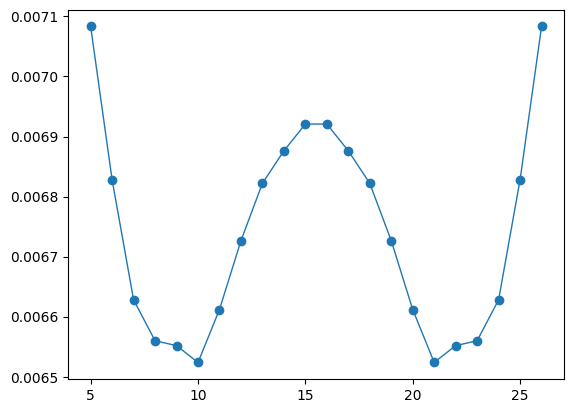

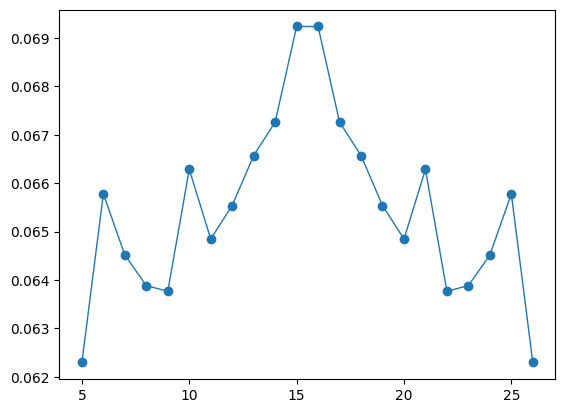

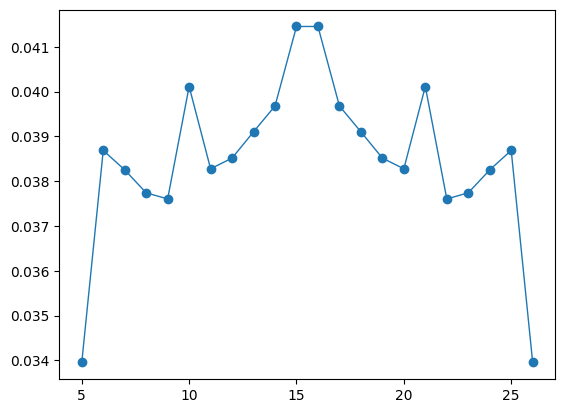

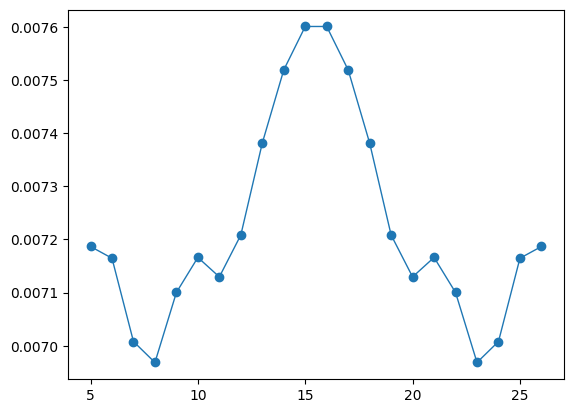

In [99]:
times = np.arange(tvals)

cut = 5

for iop in range(noperators):
    _ = plt.figure()
    _ = plt.plot(times[cut:-cut],mat_ele[iop,cut:-cut],'-o',linewidth=1)

In [100]:
mat_ele_avg = [mat_ele[iop,cut:-cut].mean() for iop in range(noperators)]


mat_ele_avg

[0.009256207750438197,
 0.0067392610458946395,
 0.06545470559146442,
 0.038488416335856764,
 0.0072212662731969265]

## analysis conf per conf

In [101]:
'''
element1 = np.empty(shape=(nconf,noperators,tvals),dtype=float)
element2 = np.empty(shape=(nconf,noperators,tvals),dtype=float)
result = np.empty(shape=(nconf,noperators,tvals),dtype=float)
mat_ele_squared = np.empty(shape=(nconf,noperators,tvals),dtype=float)
mat_ele = np.empty(shape=(nconf,noperators,tvals),dtype=float)

func_factor = np.empty(shape=(tvals),dtype=float)
func_factor = final_func(times,mps,mpst)


for iconf in range(nconf):
    for iop in range(noperators):

        element1[iconf,iop,:] = corr_3p_navg[iconf,iop,:].imag/corr_z_navg[iconf,:].real

        element2[iconf,iop,:] = corr_3p_navg[iconf,iop,::-1].imag/corr_x_navg[iconf,::-1].real

        #result[iconf,iop,:] = element1[iconf,iop,:] * np.conjugate(element2[iconf,iop,:])
        result[iconf,iop,:] = element1[iconf,iop,:] * ( - element2[iconf,iop,:] )

        mat_ele_squared[iconf,iop,:] = result[iconf,iop,:] * func_factor[:]

        mat_ele[iconf,iop,:]  = np.sqrt(mat_ele_squared[iconf,iop,:] )
'''

'\nelement1 = np.empty(shape=(nconf,noperators,tvals),dtype=float)\nelement2 = np.empty(shape=(nconf,noperators,tvals),dtype=float)\nresult = np.empty(shape=(nconf,noperators,tvals),dtype=float)\nmat_ele_squared = np.empty(shape=(nconf,noperators,tvals),dtype=float)\nmat_ele = np.empty(shape=(nconf,noperators,tvals),dtype=float)\n\nfunc_factor = np.empty(shape=(tvals),dtype=float)\nfunc_factor = final_func(times,mps,mpst)\n\n\nfor iconf in range(nconf):\n    for iop in range(noperators):\n\n        element1[iconf,iop,:] = corr_3p_navg[iconf,iop,:].imag/corr_z_navg[iconf,:].real\n\n        element2[iconf,iop,:] = corr_3p_navg[iconf,iop,::-1].imag/corr_x_navg[iconf,::-1].real\n\n        #result[iconf,iop,:] = element1[iconf,iop,:] * np.conjugate(element2[iconf,iop,:])\n        result[iconf,iop,:] = element1[iconf,iop,:] * ( - element2[iconf,iop,:] )\n\n        mat_ele_squared[iconf,iop,:] = result[iconf,iop,:] * func_factor[:]\n\n        mat_ele[iconf,iop,:]  = np.sqrt(mat_ele_squared[ic

In [102]:
mat_ele = np.empty(shape=(nconf,noperators,tvals),dtype=float)

for iconf in range(nconf):
    for iop in range(noperators):
        for t in range(tvals):
            e1 = corr_3p_navg[iconf,iop,t].imag/corr_z_navg[iconf,1].real
            e2 = corr_3p_navg[iconf,iop,tvals-1-t].imag/corr_x_navg[iconf,tvals-2].real
            #mat_ele[iconf,iop,t] = np.sqrt( e1* (-e2) * final_func(t,mps,mpst) )
            #mat_ele[iconf,iop,t] =  e1* (-e2) * final_func(t,mps,mpst)
            mat_ele[iconf,iop,t] = np.sqrt( e1* e2 )

/tmp/ipykernel_5742/1542568541.py:10: RuntimeWarning: invalid value encountered in sqrt
  mat_ele[iconf,iop,t] = np.sqrt( e1* e2 )


In [103]:
mat_ele[0,:,10:-10]

array([[0.00854102, 0.00831321, 0.0083141 , 0.00819719, 0.0079489 ,
        0.00812157, 0.00812157, 0.0079489 , 0.00819719, 0.0083141 ,
        0.00831321, 0.00854102],
       [0.00595159, 0.00535294, 0.00480697, 0.00483042, 0.0052788 ,
        0.00523672, 0.00523672, 0.0052788 , 0.00483042, 0.00480697,
        0.00535294, 0.00595159],
       [0.05408289, 0.0714485 , 0.061671  , 0.04734833, 0.04305161,
        0.04289592, 0.04289592, 0.04305161, 0.04734833, 0.061671  ,
        0.0714485 , 0.05408289],
       [0.0286839 , 0.04375504, 0.03646242, 0.02474602, 0.02043718,
        0.02003273, 0.02003273, 0.02043718, 0.02474602, 0.03646242,
        0.04375504, 0.0286839 ],
       [0.00620904, 0.00694307, 0.00634882, 0.00514921, 0.00494354,
        0.00500439, 0.00500439, 0.00494354, 0.00514921, 0.00634882,
        0.00694307, 0.00620904]])

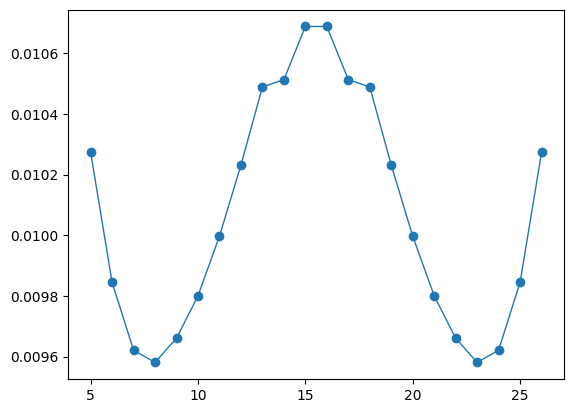

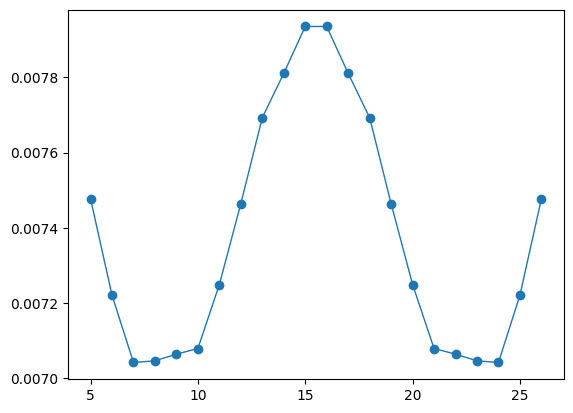

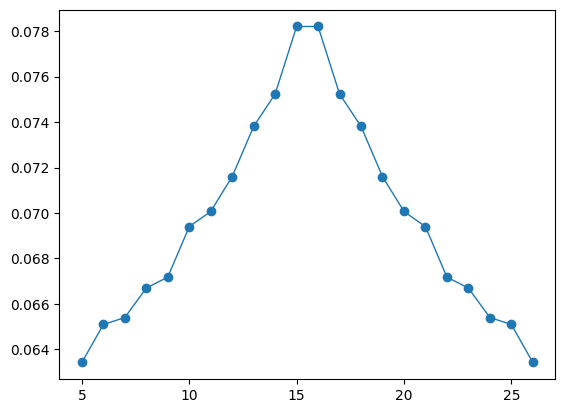

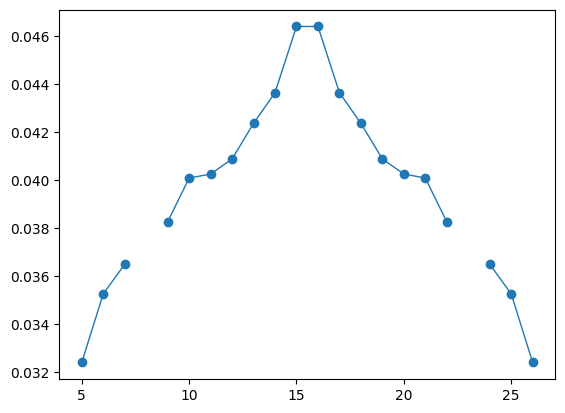

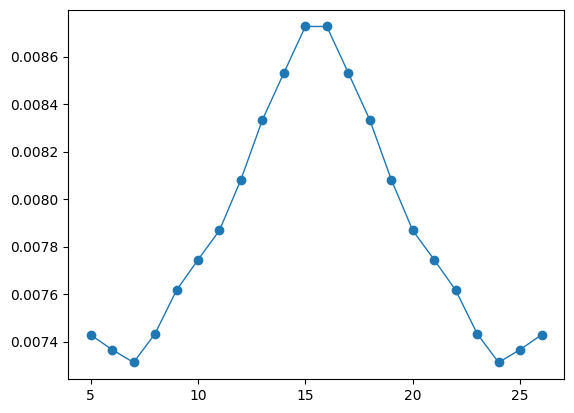

In [104]:
cut = 5

for iop in range(noperators):
    _ = plt.figure()
    #_ = plt.plot(times[cut:-cut],np.mean(mat_ele_squared,axis=0)[iop,cut:-cut],'-o',linewidth=1)
    _ = plt.plot(times[cut:-cut],np.mean(mat_ele,axis=0)[iop,cut:-cut],'-o',linewidth=1)

In [105]:
test_statistic = np.mean

mat_ele_jack = np.empty(shape=(noperators,tvals),dtype=float)
mat_ele_jack_std = np.empty(shape=(noperators,tvals),dtype=float)

for t in range(tvals):
    for iop in range(noperators):

        #data = mat_ele_squared[:,iop,t]
        data = mat_ele[:,iop,t]

        estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

        mat_ele_jack[iop,t] = estimate
        mat_ele_jack_std[iop,t] = stderr

In [62]:
'''
test_statistic = np.mean

mat_ele_jack = np.empty(shape=(noperators,tvals),dtype=float)
mat_ele_jack_std = np.empty(shape=(noperators,tvals),dtype=float)

for t in range(tvals):
    for iop in range(noperators):

        #data = mat_ele_squared[:,iop,t]
        data = mat_ele[:,iop,t]

        estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

        mat_ele_jack[iop,t] = estimate
        mat_ele_jack_std[iop,t] = stderr
        '''

'\ntest_statistic = np.mean\n\nmat_ele_jack = np.empty(shape=(noperators,tvals),dtype=float)\nmat_ele_jack_std = np.empty(shape=(noperators,tvals),dtype=float)\n\nfor t in range(tvals):\n    for iop in range(noperators):\n\n        #data = mat_ele_squared[:,iop,t]\n        data = mat_ele[:,iop,t]\n\n        estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)\n\n        mat_ele_jack[iop,t] = estimate\n        mat_ele_jack_std[iop,t] = stderr\n        '

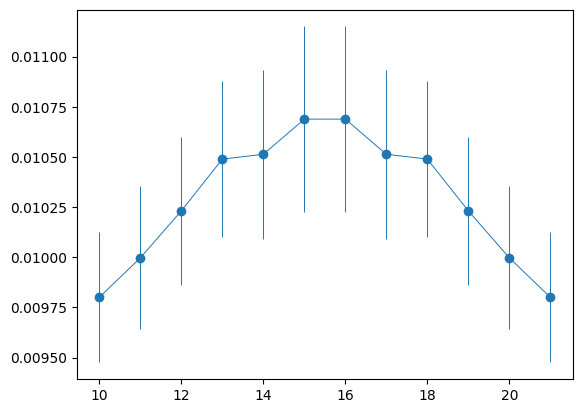

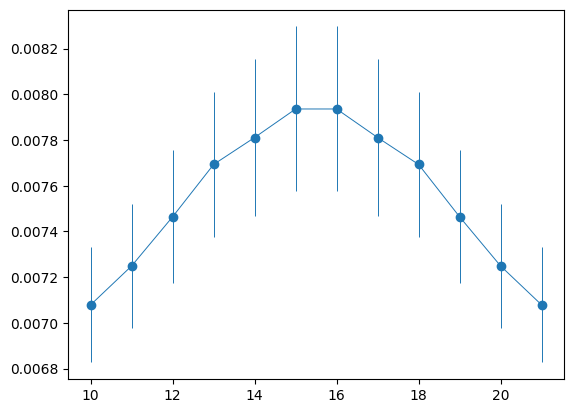

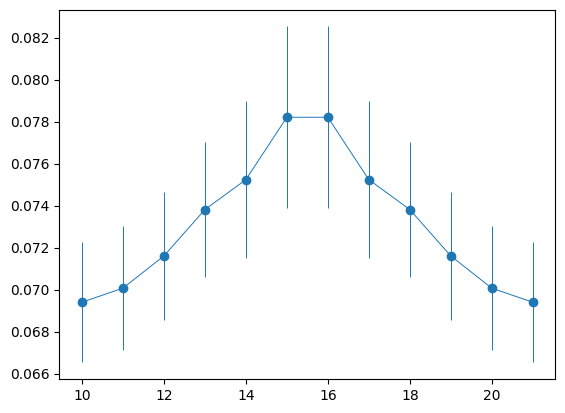

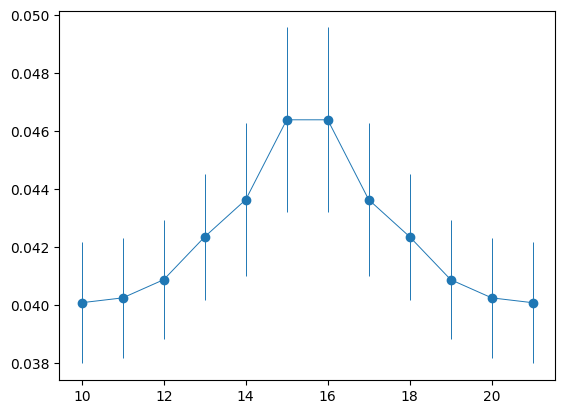

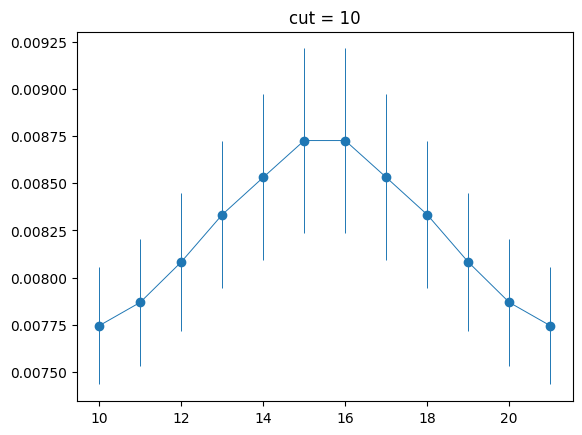

In [106]:
cut = 10

for iop in range(noperators):
    _ = plt.figure()
    _ = plt.errorbar(times[cut:-cut],mat_ele_jack[iop,cut:-cut],yerr=mat_ele_jack_std[iop,cut:-cut],marker='o',linewidth=0.7)

_ = plt.title(f"cut = {cut}")

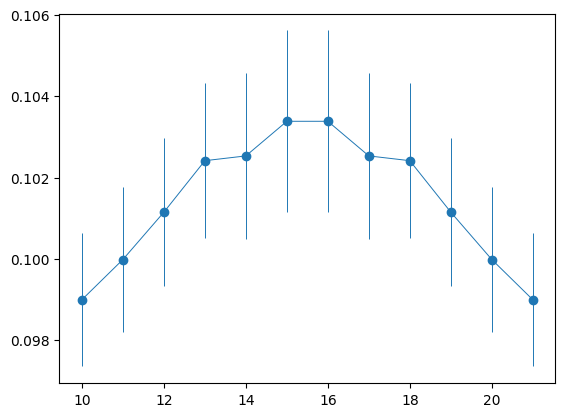

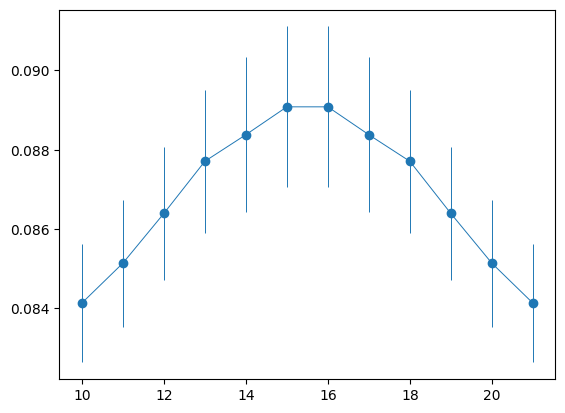

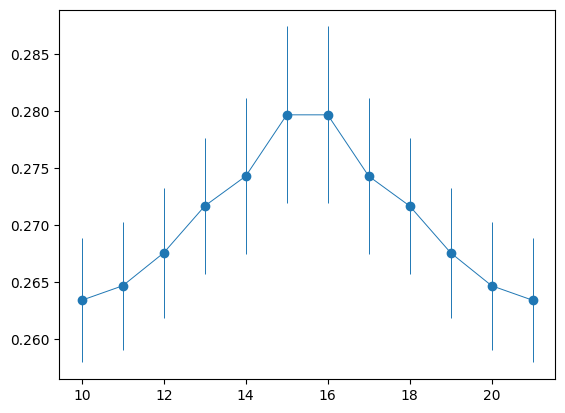

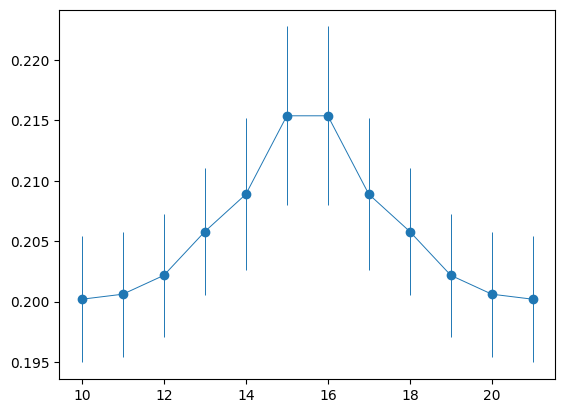

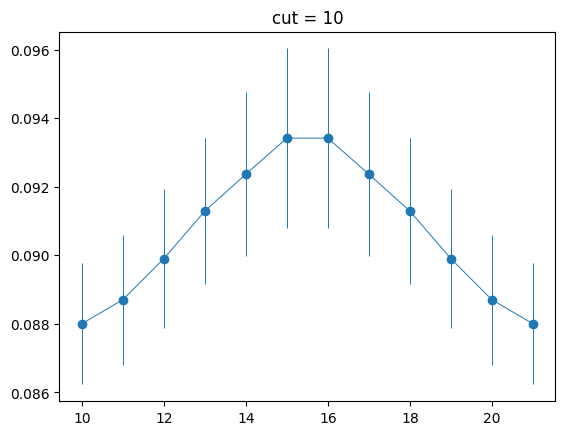

In [107]:
cut = 10

for iop in range(noperators):
    _ = plt.figure()
    _ = plt.errorbar(times[cut:-cut],np.sqrt(mat_ele_jack[iop,cut:-cut]),yerr=1/2 * mat_ele_jack_std[iop,cut:-cut]/np.sqrt(mat_ele_jack[iop,cut:-cut]),marker='o',linewidth=0.7)

_ = plt.title(f"cut = {cut}")

In [108]:
final_mat_ele = [np.sqrt(mat_ele_jack[iop,cut:-cut]).mean() for iop in range(noperators)]
final_mat_ele_std = np.sqrt(np.array([((1/2 * mat_ele_jack_std[iop,cut:-cut]/np.sqrt(mat_ele_jack[iop,cut:-cut]))**2).mean() for iop in range(noperators)]))

print(final_mat_ele)
print(final_mat_ele_std)

[0.10141079890415051, 0.08680732851130789, 0.2702237431960957, 0.2055066087535092, 0.09061420007403535]
[0.0019136  0.00177006 0.00625627 0.00580874 0.00215854]


# further analysis

## 2 points from oddrun

In [109]:
new2x_navg = all_2point_z.mean(axis=-1)[:,0,:]
new2z_navg = all_2point_x.mean(axis=-1)[:,0,:]

if verbose:
    print("(nconf),tvals")
    np.shape(new2x_navg)
    np.shape(new2z_navg)

(nconf),tvals


(991, 32)

(991, 32)

Text(0.5, 1.0, 'cut = 5')

<Figure size 640x480 with 0 Axes>

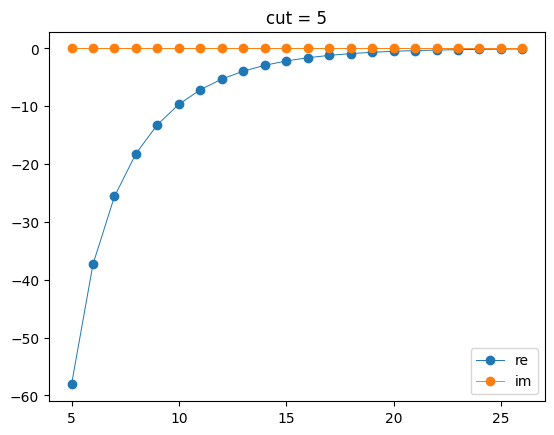

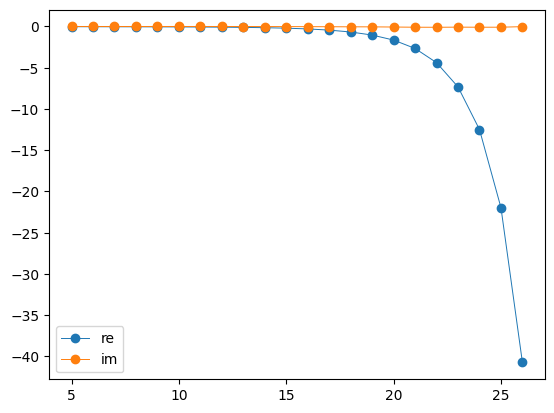

In [110]:
times=np.arange(tvals)
cut=5
plt.title(f"cut = {cut}")
plt.plot(times[cut:-cut],np.mean(new2x_navg,axis=0)[cut:-cut].real,'-o',linewidth=0.7,label='re')
plt.plot(times[cut:-cut],np.mean(new2x_navg,axis=0)[cut:-cut].imag,'-o',linewidth=0.7,label='im')
plt.legend()
plt.figure()
plt.plot(times[cut:-cut],np.mean(new2z_navg,axis=0)[cut:-cut].real,'-o',linewidth=0.7,label='re')
plt.plot(times[cut:-cut],np.mean(new2z_navg,axis=0)[cut:-cut].imag,'-o',linewidth=0.7,label='im')
plt.legend()

In [111]:
test_statistic = np.mean

new2x_navg_jack = np.empty(shape=(tvals),dtype=float)
new2x_navg_jack_std = np.empty(shape=(tvals),dtype=float)
new2z_navg_jack = np.empty(shape=(tvals),dtype=float)
new2z_navg_jack_std = np.empty(shape=(tvals),dtype=float)

for t in range(tvals):

    data = new2x_navg[:,t].real
    
    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    new2x_navg_jack[t] = estimate
    new2x_navg_jack_std[t] = stderr


    data = new2z_navg[:,t].real
    
    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    new2z_navg_jack[t] = estimate
    new2z_navg_jack_std[t] = stderr

Text(0.5, 1.0, 'cut = 5')

<ErrorbarContainer object of 3 artists>

<Figure size 640x480 with 0 Axes>

<ErrorbarContainer object of 3 artists>

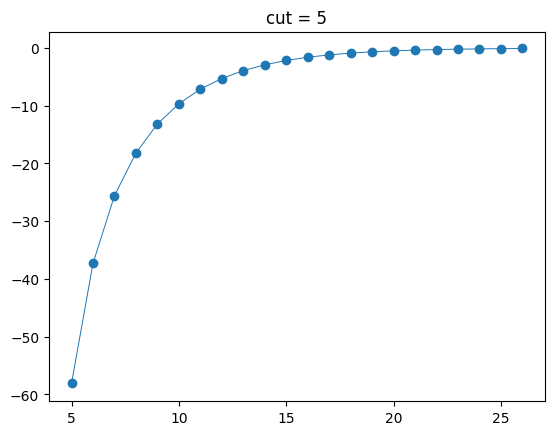

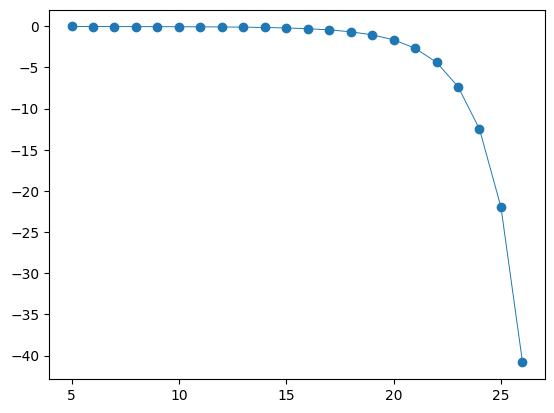

In [112]:
times=np.arange(tvals)
cut=5
plt.title(f"cut = {cut}")
plt.errorbar(times[cut:-cut],new2x_navg_jack[cut:-cut],yerr=new2x_navg_jack_std[cut:-cut],marker='o',linewidth=0.7)
plt.figure()
plt.errorbar(times[cut:-cut],new2z_navg_jack[cut:-cut],yerr=new2z_navg_jack_std[cut:-cut],marker='o',linewidth=0.7)

In [113]:
newnconf = np.shape(new2x_navg_jack)[0]
new_eff_mass_x = np.empty(shape=(newnconf,tvals-1))
new_eff_mass_z = np.empty(shape=(newnconf,tvals-1))

for iconf in range(newnconf):
    new_eff_mass_x[iconf,:] = np.array([np.log(new2x_navg[iconf,i].real/new2x_navg[iconf,i+1].real) for i in range(tvals-1)])
    #new_eff_mass_z[iconf,:] = np.array([np.log(new2z_navg[iconf,i-1].real/new2z_navg[iconf,i].real) for i in range(1,tvals)])
    new_eff_mass_z[iconf,:] = np.array([np.log(new2z_navg[iconf,tvals-i].real/new2z_navg[iconf,tvals-i-1].real) for i in range(1,tvals)])

if verbose:
    print("(nconf,tvals-1)")
    print(np.shape(eff_mass_x))
    print(np.shape(eff_mass_z))

(nconf,tvals-1)
(100, 31)
(100, 31)


/tmp/ipykernel_5742/2178930174.py:6: RuntimeWarning: divide by zero encountered in log
  new_eff_mass_x[iconf,:] = np.array([np.log(new2x_navg[iconf,i].real/new2x_navg[iconf,i+1].real) for i in range(tvals-1)])
/tmp/ipykernel_5742/2178930174.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  new_eff_mass_x[iconf,:] = np.array([np.log(new2x_navg[iconf,i].real/new2x_navg[iconf,i+1].real) for i in range(tvals-1)])
/tmp/ipykernel_5742/2178930174.py:6: RuntimeWarning: invalid value encountered in log
  new_eff_mass_x[iconf,:] = np.array([np.log(new2x_navg[iconf,i].real/new2x_navg[iconf,i+1].real) for i in range(tvals-1)])
/tmp/ipykernel_5742/2178930174.py:8: RuntimeWarning: divide by zero encountered in log
  new_eff_mass_z[iconf,:] = np.array([np.log(new2z_navg[iconf,tvals-i].real/new2z_navg[iconf,tvals-i-1].real) for i in range(1,tvals)])
/tmp/ipykernel_5742/2178930174.py:8: RuntimeWarning: invalid value encountered in log
  new_eff_mass_z[iconf,:] = np.array([np.log(new2

In [120]:
new_eff_mass_z = np.nan_to_num(new_eff_mass_z,nan=0)

<Figure size 640x480 with 0 Axes>

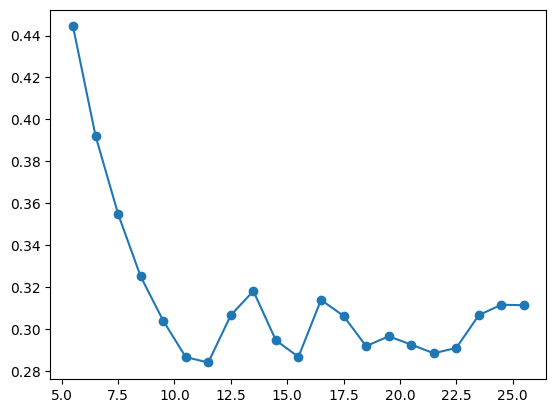

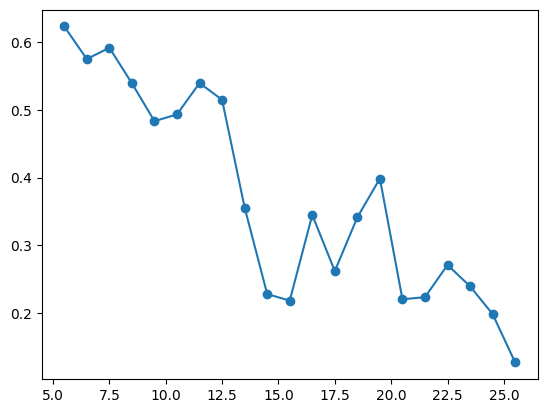

In [122]:
cut = 5
plt.plot(eff_mass_times[cut:-cut],new_eff_mass_x.mean(axis=0)[cut:-cut],'-o')
plt.figure()
plt.plot(eff_mass_times[cut:-cut],new_eff_mass_z.mean(axis=0)[cut:-cut],'-o')

In [124]:
new_eff_mass_x_jack = np.empty(shape=(tvals-1),dtype=float)
new_eff_mass_x_jack_std = np.empty(shape=(tvals-1),dtype=float)

new_eff_mass_z_jack = np.empty(shape=(tvals-1),dtype=float)
new_eff_mass_z_jack_std = np.empty(shape=(tvals-1),dtype=float)

for t in range(tvals-1):

    data = new_eff_mass_x[:,t].real

    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    new_eff_mass_x_jack[t] = estimate
    new_eff_mass_x_jack_std[t] = stderr



    data = new_eff_mass_z[:,t].real

    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    new_eff_mass_z_jack[t] = estimate
    new_eff_mass_z_jack_std[t] = stderr

/home/tag-e/università/Magistrale/tesi/codice/myCode/python_analysis/my_env/lib/python3.10/site-packages/astropy/stats/jackknife.py:163: RuntimeWarning: invalid value encountered in scalar subtract
  bias = (n - 1) * (mean_jack_stat - stat_data)
/home/tag-e/università/Magistrale/tesi/codice/myCode/python_analysis/my_env/lib/python3.10/site-packages/astropy/stats/jackknife.py:168: RuntimeWarning: invalid value encountered in subtract
  * np.mean((jack_stat - mean_jack_stat) * (jack_stat - mean_jack_stat), axis=0)
/home/tag-e/università/Magistrale/tesi/codice/myCode/python_analysis/my_env/lib/python3.10/site-packages/astropy/stats/jackknife.py:175: RuntimeWarning: invalid value encountered in add
  conf_interval = estimate + z_score * np.array((-std_err, std_err))


Text(0.5, 1.0, 'cut=8')

<ErrorbarContainer object of 3 artists>

<Figure size 640x480 with 0 Axes>

<ErrorbarContainer object of 3 artists>

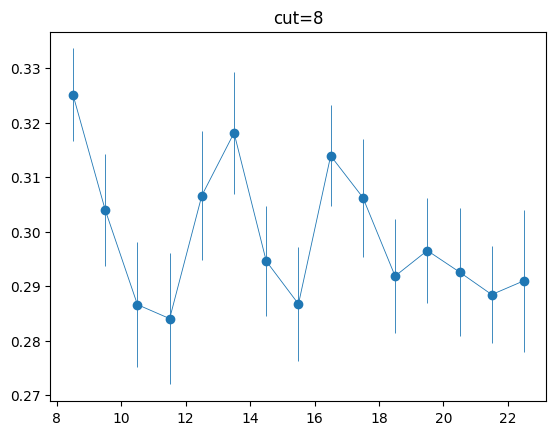

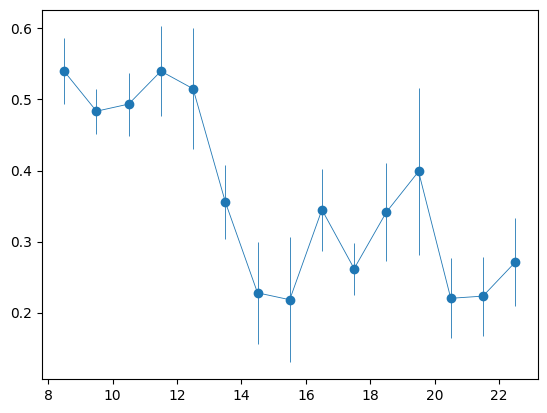

In [125]:
cut=8
plt.title(f"cut={cut}")
plt.errorbar(eff_mass_times[cut:-cut],new_eff_mass_x_jack[cut:-cut],yerr=new_eff_mass_x_jack_std[cut:-cut],marker='o',linewidth=0.6)

plt.figure()
plt.errorbar(eff_mass_times[cut:-cut],new_eff_mass_z_jack[cut:-cut],yerr=new_eff_mass_z_jack_std[cut:-cut],marker='o',linewidth=0.6)

In [126]:
np.mean(new_eff_mass_x_jack[cut:-cut])
np.sqrt(np.mean( new_eff_mass_x_jack_std[cut:-cut]**2 ))


np.mean(new_eff_mass_z_jack[cut:-cut])
np.sqrt(np.mean( new_eff_mass_z_jack_std[cut:-cut]**2 ))

0.29909147854651263

0.010702740538962833

0.3622974800381071

0.06596886333707894

# complete analysis from oddrun

## reading

In [3]:
dirName = '../../data_from_scp/'
name = 'odd_run18.odd_df2_4fop'
datName = name + '.dat'

fileName = dirName + datName

In [4]:
noperators=5 #number of operators (VA - AV - SP - PS - TT~)

verbose=True #True to print more output

step = 1 #steps at which configurations are read

early_stop = 0

In [5]:
#the correlators array will be stored in a dict having as keys the configurations
conf_dict = {}
conf_dict_2p = {}

#list with configurations number
conf_num_list = []

##### reading data from binary dat file #####
with open(fileName, mode='rb') as file: # b is important -> binary
    fileContent = file.read()

    #header is made up of 5 integers, 5x4=20byte, and 2 double, 2x8=16byte
    header_size= 6*4 +2*8

    #first 16 byte are four 4-byte integers
    ncorr, nnoise, tvals, noise_type, check_gauge_inv, random_conf, csw, cf = struct.unpack("iiiiiidd", fileContent[:header_size])

    #initialization of correlators' variables
    k1=['']*ncorr
    k2=['']*ncorr
    k3=['']*ncorr
    k4=['']*ncorr
    mu1=['']*ncorr
    mu2=['']*ncorr
    mu3=['']*ncorr
    mu4=['']*ncorr
    typeA=['']*ncorr
    typeB=['']*ncorr
    x0=['']*ncorr
    z0=['']*ncorr

    
    #each correlator has an header of size given by 8x8 + 4x4 = 80byte
    corr_header_size = 8*8 + 4*4
    
    #then there are ncorr block, 8x8 + 4x4 (8 double and 4 int) with the following structure 
    for i in range(ncorr):
         k1[i], k2[i], k3[i], k4[i], mu1[i], mu2[i], mu3[i], mu4[i], typeA[i], typeB[i], x0[i], z0[i] = struct.unpack("ddddddddiiii",fileContent[header_size+corr_header_size*i:header_size+corr_header_size*(i+1)])



    #initialization of correlators array
    conn_corr = np.empty(shape=(ncorr,noperators,tvals,nnoise,nnoise),dtype=complex) #connected correlators
    disc_corr = np.empty(shape=(ncorr,noperators,tvals,nnoise,nnoise),dtype=complex) #disconnected correlators

    x_corr = np.empty(shape=(ncorr,tvals,nnoise),dtype=complex)
    z_corr = np.empty(shape=(ncorr,tvals,nnoise),dtype=complex)


    #offset due to 3 points (see comment below)
    offset_3point = nnoise    *   nnoise   *  tvals                  * noperators        * 2                                    * 2         * 8 
    offset_2point = nnoise * tvals * 2                   * 2         * 8

    offset_diag3 = nnoise    *   nnoise   *  tvals                  * noperators        * 2         * 8
    offset_diag2 = nnoise * tvals                   * 2         * 8

    #configuration start right after the header
    first_conf = header_size+corr_header_size*ncorr
    
    #we compute the lenght of the data block for each configuration
    #          nnoise_A  *  nnoise_B  *  time lenght of lattice * noperators   * ncorrelators * 2 (diagrams=connected+disconnected)  * 2 (re+im) * 8 (sizeof(double))  + sizeof(int) (= conf_number)
    conf_len = nnoise    *   nnoise   *  tvals                  * noperators   * ncorr        * 2                                    * 2         * 8                    + 4
    #                     ncorr * nnoise * tvaks * 2 (x+z 2point corr) * 2 (re+im) * 8 (sizeof(double))
    conf_len = conf_len + ncorr * nnoise * tvals * 2                   * 2         * 8

    #starting right after the header we read each configuration block
    for start_conf in range(first_conf, len(fileContent)-conf_len*early_stop, conf_len*step):
    #for start_conf in range(first_conf, len(fileContent)-conf_len, conf_len):

        #breaks loop if the file does not contain the whole correlator for the given configuration
        if start_conf+conf_len > len(fileContent) :
            break

        #reading of the configuration number
        conf_number = struct.unpack("i",fileContent[start_conf:start_conf+4])[0]
        if verbose==True:
            print(f"Reading: Gauge Conf = {conf_number}\n")

        #store of conf num
        if conf_number not in conf_num_list:
            conf_num_list.append(conf_number)

        #initialize to 0 the array storing the correlators
        conn_corr.fill(complex(0,0))
        disc_corr.fill(complex(0,0))
        #same for 2 point
        x_corr.fill(complex(0,0))
        z_corr.fill(complex(0,0))

        start_reading = start_conf+4

        #loop over the correlators (ncorr blocks of...)
        for ic in range(ncorr):

            #reading of chunk with conn corr
            
            #loop over the operators (...noperators blocs of...)
            for op in range(noperators):
                #loop over time values (...tvals blocks of...)
                for t in range(tvals):
                    #loop over noiseB vectors (...nnoise blocks of...)
                    for noiseB in range(nnoise):
                        #loop over noiseA vectors (...nnoise blocks of...)
                        for noiseA in range(nnoise):
                    
                            #reading of re and im part of correlators   (...complex numbers)
                            
                            #connected correlators

                            #begin of reading point (8=sizeof(double)) (last 2 is number of diagrams)
                            #start_reading = start_conf+4 + 2*8*noiseA+2*8*nnoise*(noiseB+nnoise*(t+tvals*(op+noperators*2*ic)))
                            
                            #reading of real and complex for connected corr
                            re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])

                            #store complex number
                            conn_corr[ic][op][t][noiseB][noiseA] = complex(re,im)


                            #disconnected correlators

                            #begin of reading point (8=sizeof(double)) (last 2 is number of diagrams)
                            #start_reading = start_conf+4 + 2*8*noiseA+2*8*nnoise*(noiseB+nnoise*(t+tvals*(op+noperators*(2*ic+1))))

                            #reading of real and complex for connected corr
                            #re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])
                            re,im = struct.unpack("dd",fileContent[start_reading+offset_diag3:start_reading+offset_diag3+16])

                            #store complex number
                            disc_corr[ic][op][t][noiseB][noiseA] = complex(re,im)

                            #update start reading
                            start_reading = start_reading+16

                            ############# new reading #########

                            #start_reading  = start_conf + 4 + 2 * 2*8 * (noiseA + nnoise*(noiseB + nnoise*(t + tvals*(op + noperators*ic ) ) ) )

                            #re_con, im_con, re_disc, im_disc = struct.unpack("dddd",fileContent[start_reading:start_reading+2*2*8])
                            #conn_corr[ic,op,t,noiseB,noiseA] = complex(re_con,im_con)
                            #disc_corr[ic,op,t,noiseB,noiseA] = complex(re_disc,im_disc)

            #update start reading for the disconnected part
            start_reading = start_reading + offset_diag3
            
            if(ic==0):
                print(start_reading+16)
            
            #reading of 2 point functions
            for t in range(tvals):
                for inoise in range(nnoise):
                    #start_reading = start_conf + 4 + offset_3point + 2*8*(inoise+nnoise*(t+tvals*2*ic)) #last 2 is for 2point in x and z
                    re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])
                    x_corr[ic][t][inoise] = complex(re,im)
                    #start_reading = start_conf + 4 + offset_3point + 2*8*(inoise+nnoise*(t+tvals*(2*ic+1))) 
                    re,im = struct.unpack("dd",fileContent[start_reading+offset_diag2:start_reading+offset_diag2+16])
                    z_corr[ic][t][inoise] = complex(re,im)

                    #update start reading
                    start_reading = start_reading+16
            #update start reading for the 2point with source in z
            start_reading = start_reading + offset_diag2

        #store of correlators associated to the given configuration
        if str(conf_number) not in conf_dict.keys():
            conf_dict[str(conf_number)] = (conn_corr.copy(),disc_corr.copy())
            conf_dict_2p[str(conf_number)] = (x_corr.copy(),z_corr.copy())
        else:
            conf_dict[str(conf_number)+"_GaugeInvCheck"] = (conn_corr.copy(),disc_corr.copy())
            conf_dict_2p[str(conf_number)+"_GaugeInvCheck"] = (x_corr.copy(),z_corr.copy())

Reading: Gauge Conf = 1

1152140
Reading: Gauge Conf = 2

2319504
Reading: Gauge Conf = 3

3486868
Reading: Gauge Conf = 4

4654232
Reading: Gauge Conf = 5

5821596
Reading: Gauge Conf = 6

6988960
Reading: Gauge Conf = 7

8156324
Reading: Gauge Conf = 8

9323688
Reading: Gauge Conf = 9

10491052
Reading: Gauge Conf = 10

11658416
Reading: Gauge Conf = 11

12825780
Reading: Gauge Conf = 12

13993144
Reading: Gauge Conf = 13

15160508
Reading: Gauge Conf = 14

16327872
Reading: Gauge Conf = 15

17495236
Reading: Gauge Conf = 16

18662600
Reading: Gauge Conf = 17

19829964
Reading: Gauge Conf = 18

20997328
Reading: Gauge Conf = 19

22164692
Reading: Gauge Conf = 20

23332056
Reading: Gauge Conf = 21

24499420
Reading: Gauge Conf = 22

25666784
Reading: Gauge Conf = 23

26834148
Reading: Gauge Conf = 24

28001512
Reading: Gauge Conf = 25

29168876
Reading: Gauge Conf = 26

30336240
Reading: Gauge Conf = 27

31503604
Reading: Gauge Conf = 28

32670968
Reading: Gauge Conf = 29

33838332
Re

In [6]:
#construction of array with names and numbers of configurations
conf_names = list(conf_dict.keys())[0::1+check_gauge_inv]
conf_list = [int(conf) for conf in conf_names ]
nconf = len(conf_list)

In [7]:
#creation of a numpy array with all the correlators
all_correlators = np.empty(shape=(nconf,2,ncorr,noperators,tvals,nnoise,nnoise),dtype=complex) #2 is for connected and disconnected
for iconf,nameconf in enumerate(conf_names):
    all_correlators[iconf] = conf_dict[nameconf]

if verbose:
    print("(nconf, pieces, ncorrelators, noperators, tvals, nnoise, nnoise)")
    print(np.shape(all_correlators))

(nconf, pieces, ncorrelators, noperators, tvals, nnoise, nnoise)
(991, 2, 1, 5, 32, 15, 15)


In [8]:
#analogous for 2 points func
all_2point_x = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)
all_2point_z = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)
for iconf,nameconf in enumerate(conf_names):
    all_2point_x[iconf] = conf_dict_2p[nameconf][0]
    all_2point_z[iconf] = conf_dict_2p[nameconf][1]


if verbose:
    print("(nconf, ncorrelators, tvals, nnoise)")
    print(np.shape(all_2point_x))
    print(np.shape(all_2point_z))

(nconf, ncorrelators, tvals, nnoise)
(991, 1, 32, 15)
(991, 1, 32, 15)


## Data to be used

In [17]:
corr_3p = all_correlators[:,0,0,:,:,:,:] + all_correlators[:,1,0,:,:,:,:]
corr_3p_navg = corr_3p.mean(axis=-1).mean(axis=-1)

corr_x = all_2point_x[:,0,:,:]
corr_x_navg = corr_x.mean(axis=-1)

corr_z = all_2point_z[:,0,:,:]
corr_z_navg = corr_z.mean(axis=-1)


if verbose:
    print("(nconf',tvals)")
    print(np.shape(corr_x_navg))
    print(np.shape(corr_z_navg))
    print("(nconf,noperators,tvals)")
    print(np.shape(corr_3p_navg))

(nconf',tvals)
(991, 32)
(991, 32)
(nconf,noperators,tvals)
(991, 5, 32)


## jackknife last

In [10]:
#for each conf we compute the mat ele squared

mat_ele_squared = np.empty(shape=(nconf,noperators,tvals),dtype=complex) #in general complex

for iconf in range(nconf):
    for iop in range(noperators):
        for t in range(tvals):
            mat_ele_squared[iconf,iop,t] = corr_3p_navg[iconf,iop,t] * np.conjugate(corr_3p_navg[iconf,iop,tvals-1-t]) / ( corr_z_navg[iconf,1] * corr_x_navg[iconf,tvals-2] )

In [182]:
corr_3p_navg[0,0,5]

np.conjugate(corr_3p_navg[0,0,tvals-1-5])

corr_3p_navg[0,0,5] * np.conjugate(corr_3p_navg[0,0,tvals-1-5])

(6.369035845126561e-05+8.439354944480589e-05j)

(6.342184407982875e-05-0.0001605611177343505j)

(1.758968261151178e-08-4.873800607604845e-09j)

In [12]:
#jackknife
test_statistic = np.mean

mat_ele_squared_jack = np.empty(shape=(noperators,tvals),dtype=float)
mat_ele_squared_jack_std = np.empty(shape=(noperators,tvals),dtype=float)

mat_ele_jack = np.empty(shape=(noperators,tvals),dtype=float)
mat_ele_jack_std = np.empty(shape=(noperators,tvals),dtype=float)

for t in range(tvals):
    for iop in range(noperators):

        data = mat_ele_squared[:,iop,t].real

        estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

        mat_ele_squared_jack[iop,t] = estimate
        mat_ele_squared_jack_std[iop,t] = stderr


        data = np.sqrt( mat_ele_squared[:,iop,t].real.clip(min=0) )

        estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

        mat_ele_jack[iop,t] = estimate
        mat_ele_jack_std[iop,t] = stderr

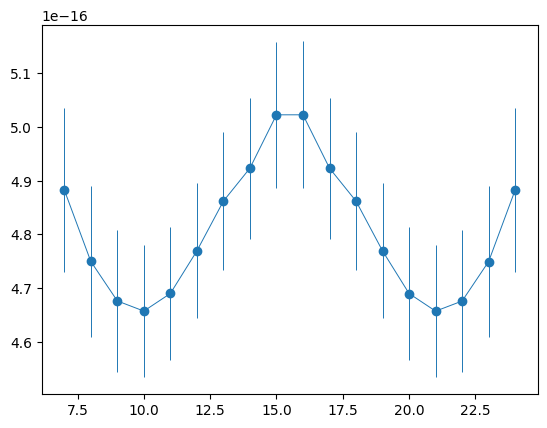

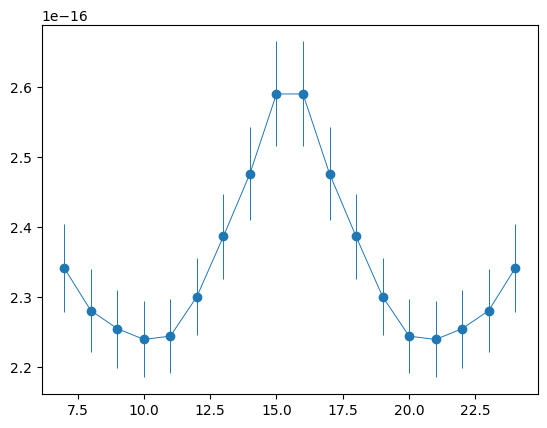

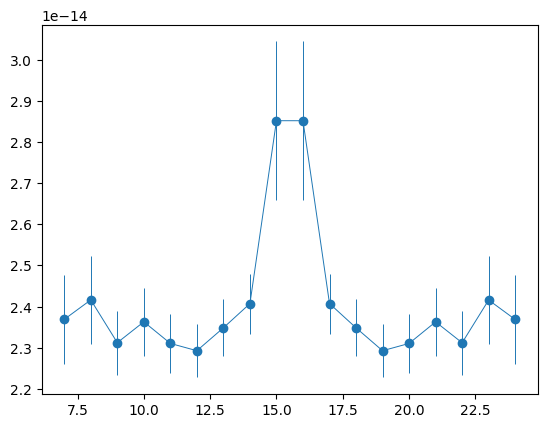

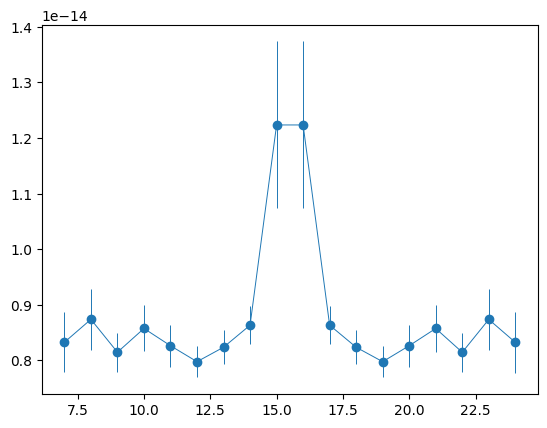

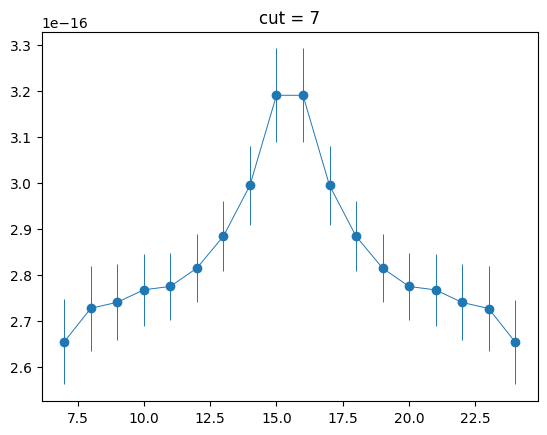

In [165]:
times = np.arange(tvals)
cut = 7

for iop in range(noperators):
    _ = plt.figure()
    _ = plt.errorbar(times[cut:-cut],mat_ele_squared_jack[iop,cut:-cut],yerr=mat_ele_squared_jack_std[iop,cut:-cut],marker='o',linewidth=0.7)

_ = plt.title(f"cut = {cut}")

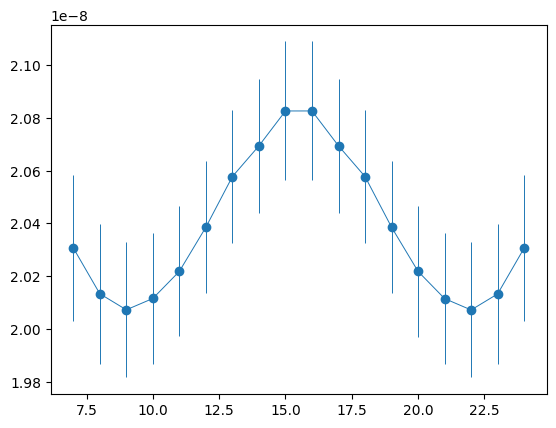

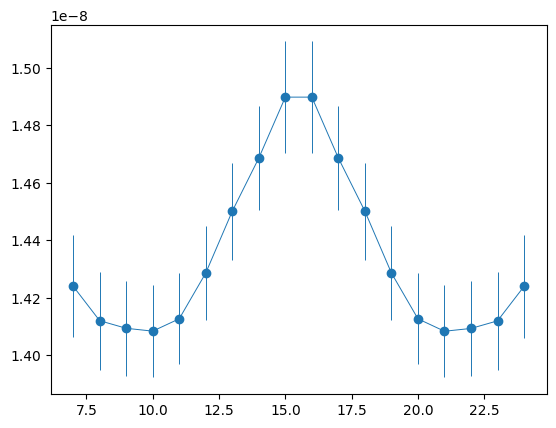

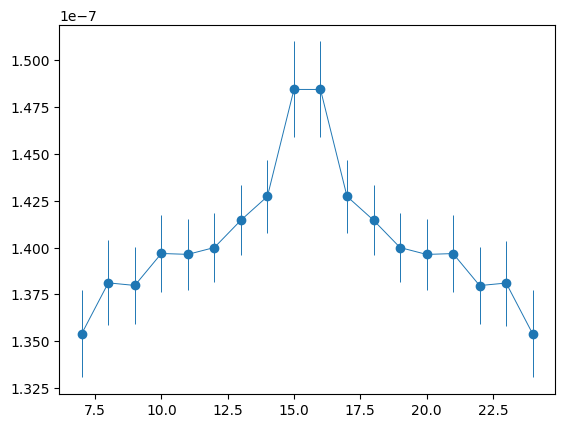

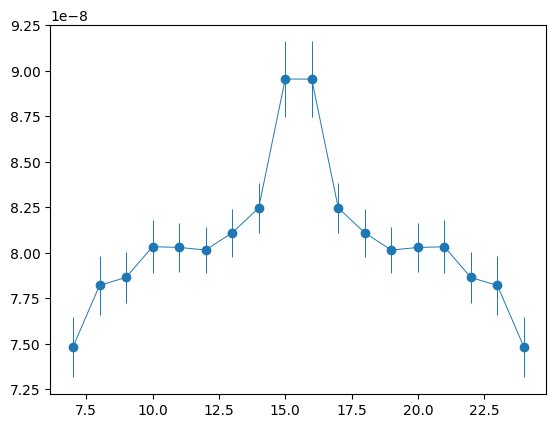

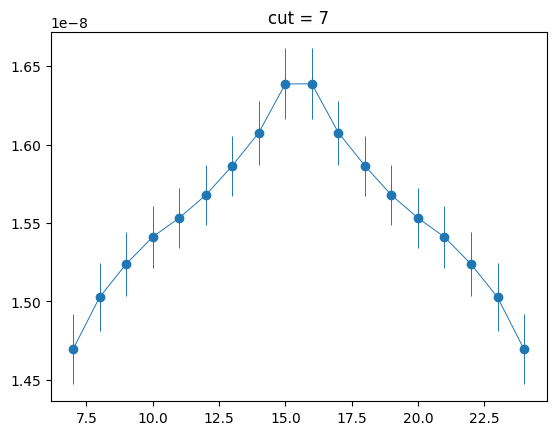

In [168]:
times = np.arange(tvals)
cut = 7

for iop in range(noperators):
    _ = plt.figure()
    _ = plt.errorbar(times[cut:-cut],mat_ele_jack[iop,cut:-cut],yerr=mat_ele_jack_std[iop,cut:-cut],marker='o',linewidth=0.7)

_ = plt.title(f"cut = {cut}")

In [14]:
cut = 7


mat_ele_final = [np.mean(mat_ele_jack[iop,cut:-cut]) for iop in range(noperators) ]
mat_ele_final_std = [np.sqrt( np.mean( mat_ele_jack_std[iop,cut:-cut]**2 ) ) for iop in range(noperators) ]

for iop,ele in enumerate(mat_ele_final):
    print(f"{round(ele,11)} +- {round(mat_ele_final_std[iop],11)}\n")

2.037e-08 +- 2.6e-10

1.434e-08 +- 1.7e-10

1.4038e-07 +- 2.1e-09

8.062e-08 +- 1.52e-09

1.555e-08 +- 2.1e-10



### grafici buoni

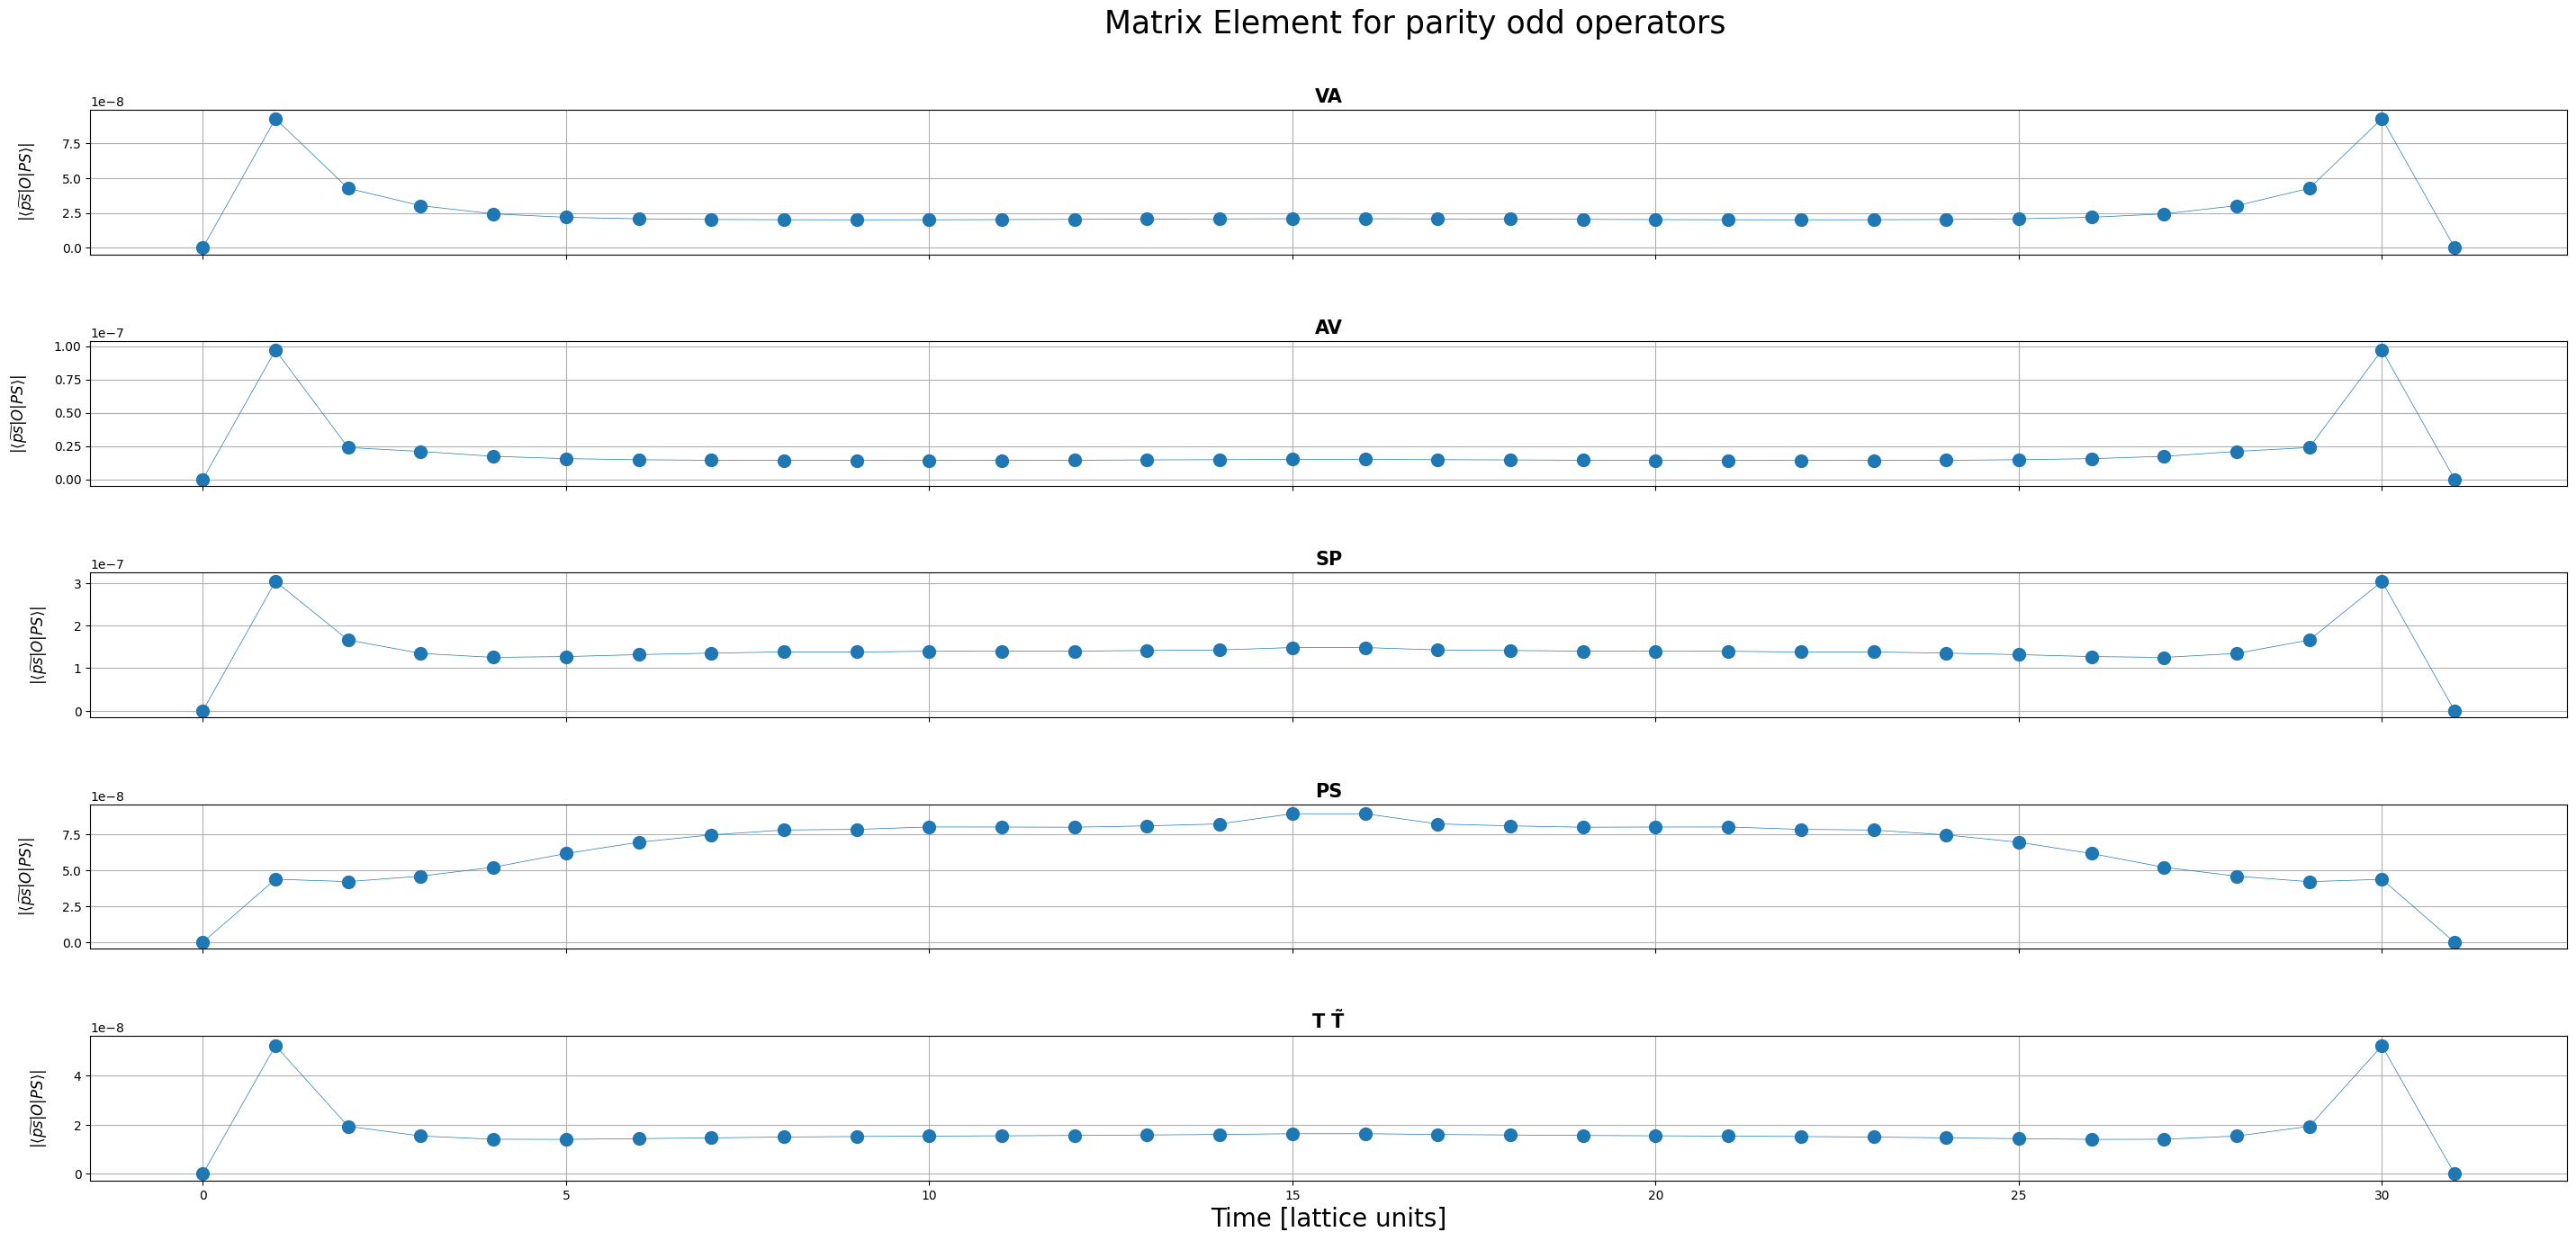

In [25]:
#times on x axis
times = np.arange(0,tvals)

op_names = ["VA","AV","SP","PS",r'T $\mathbf{\~{T}}$']

#create figure and axis
fig, ax_list = plt.subplots(nrows=noperators, ncols=1, sharex=True, sharey=False, figsize=(32, 14))

for iop in range(noperators):
    _ = ax_list[iop].errorbar(times,mat_ele_jack[iop,:],yerr=mat_ele_jack_std[iop,:],marker='o',linestyle='solid',markersize=10,linewidth=0.5,elinewidth=2)
    ax_list[iop].grid()
    _ = ax_list[iop].set_title(op_names[iop],fontsize=15,weight="bold")
    _ = ax_list[iop].set_ylabel(r'$\left|\left<\widetilde{ps}|O|PS\right>\right|$',rotation=90,labelpad=20,fontsize=12)

_ = plt.suptitle("Matrix Element for parity odd operators",fontsize=25)

#adjust subplot spacing
plt.subplots_adjust(left=0.04,
                        bottom=0.05, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.6)

#set x label
#fig.supylabel("G(t)",rotation=0,fontsize=20)
_ = plt.xlabel('Time [lattice units]',fontsize=20)

plt.savefig('matrix_element_first_analysis/matrix_element_all.png')

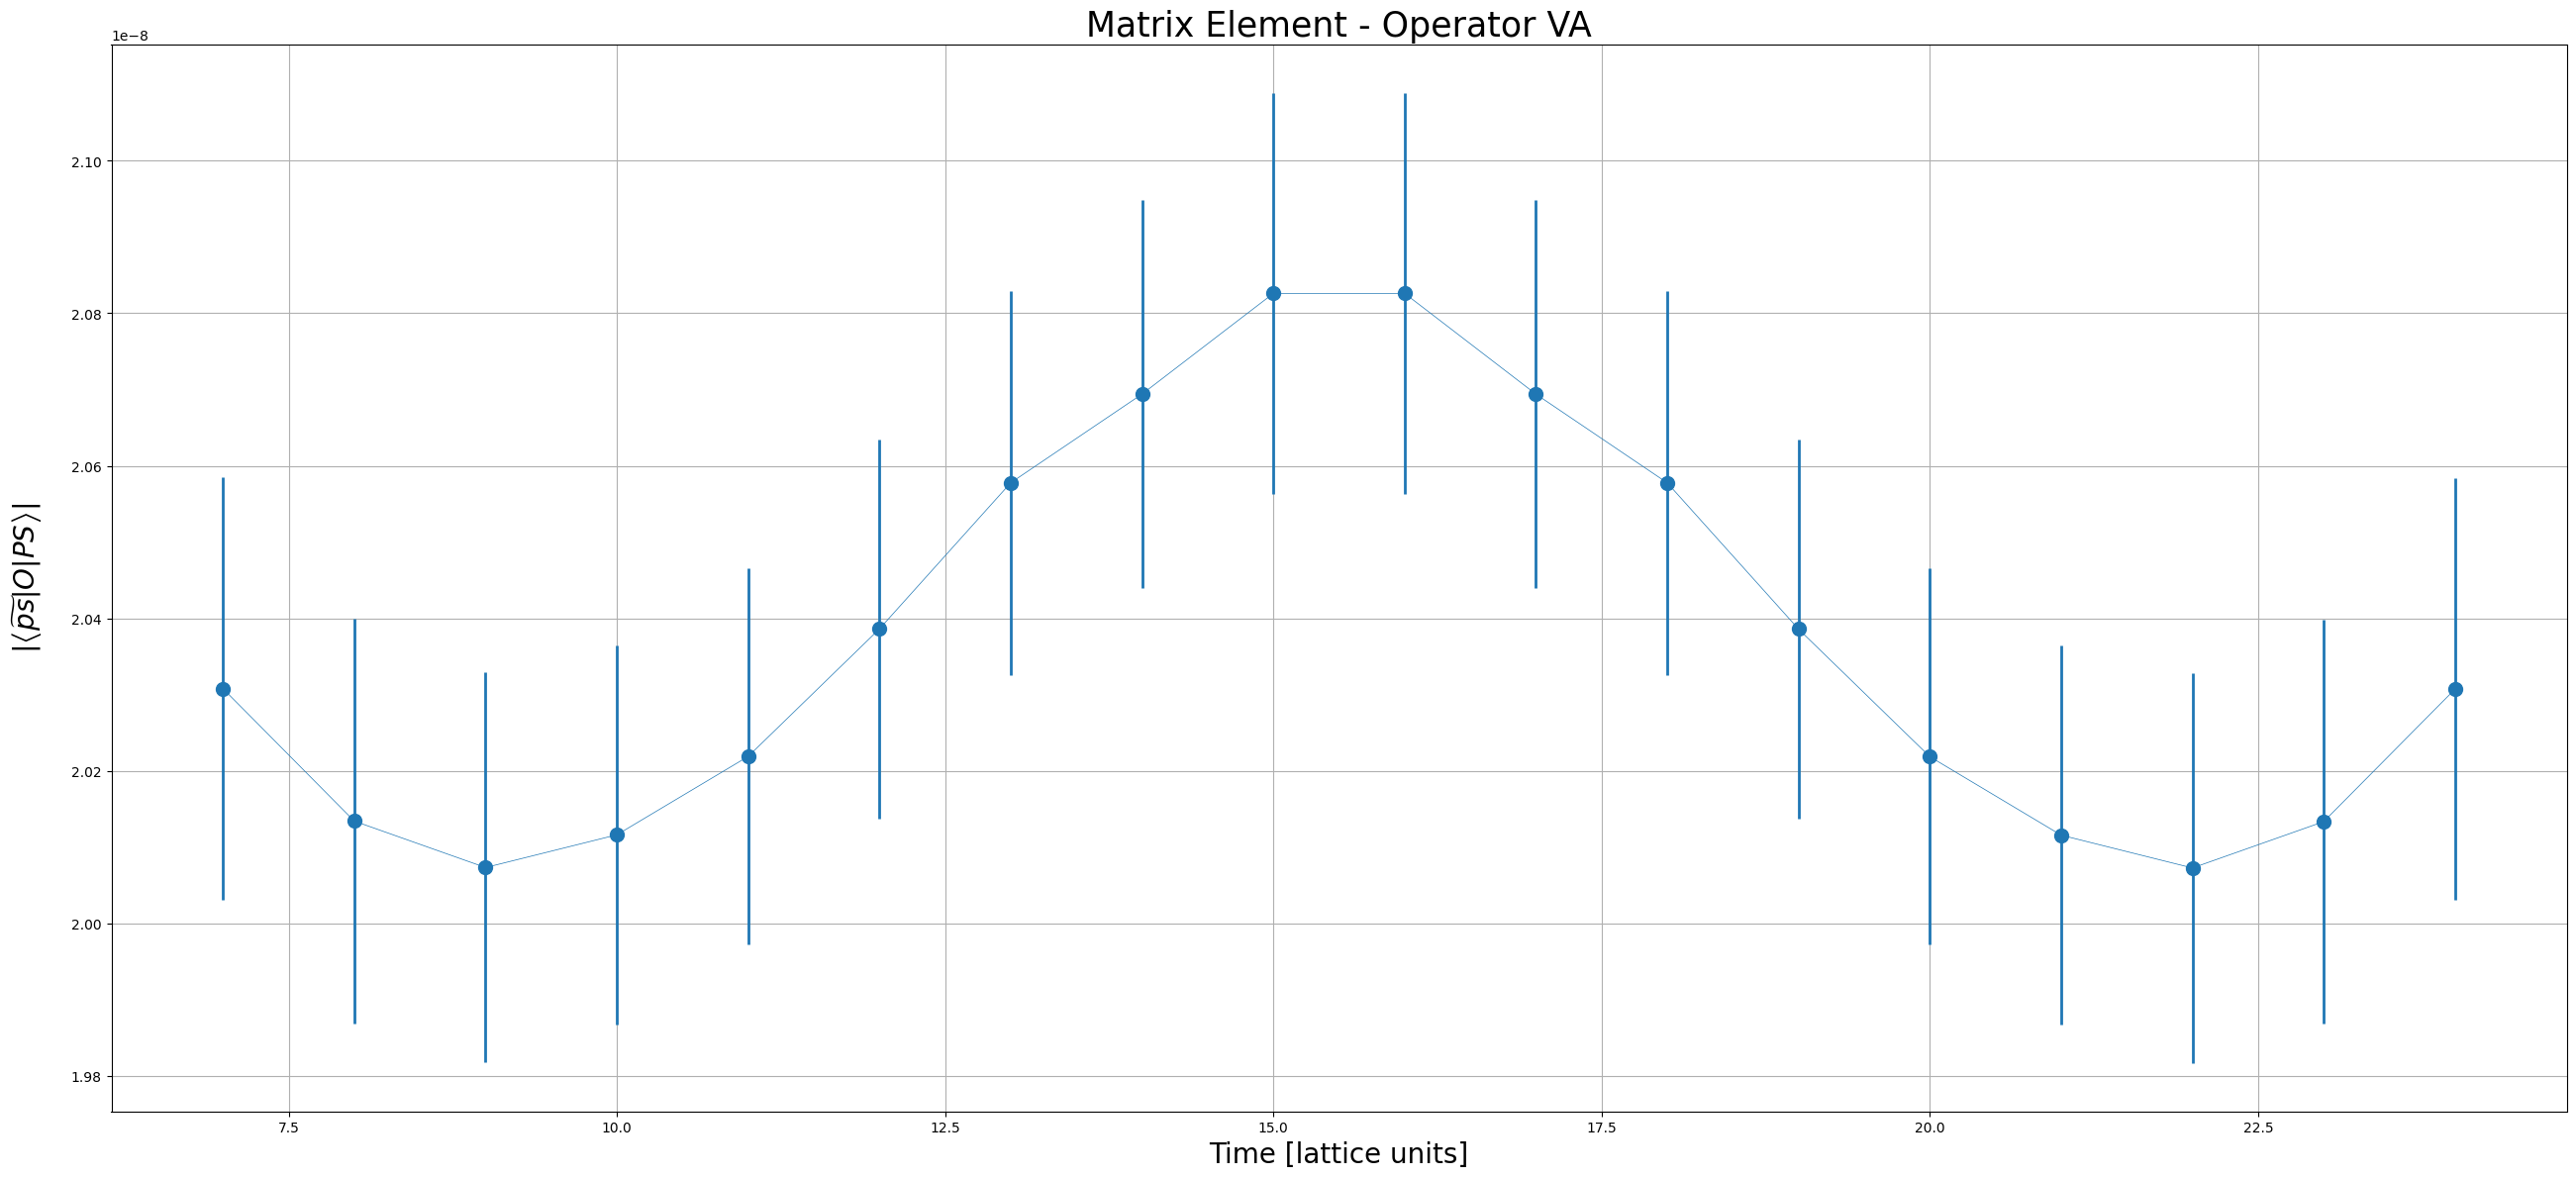

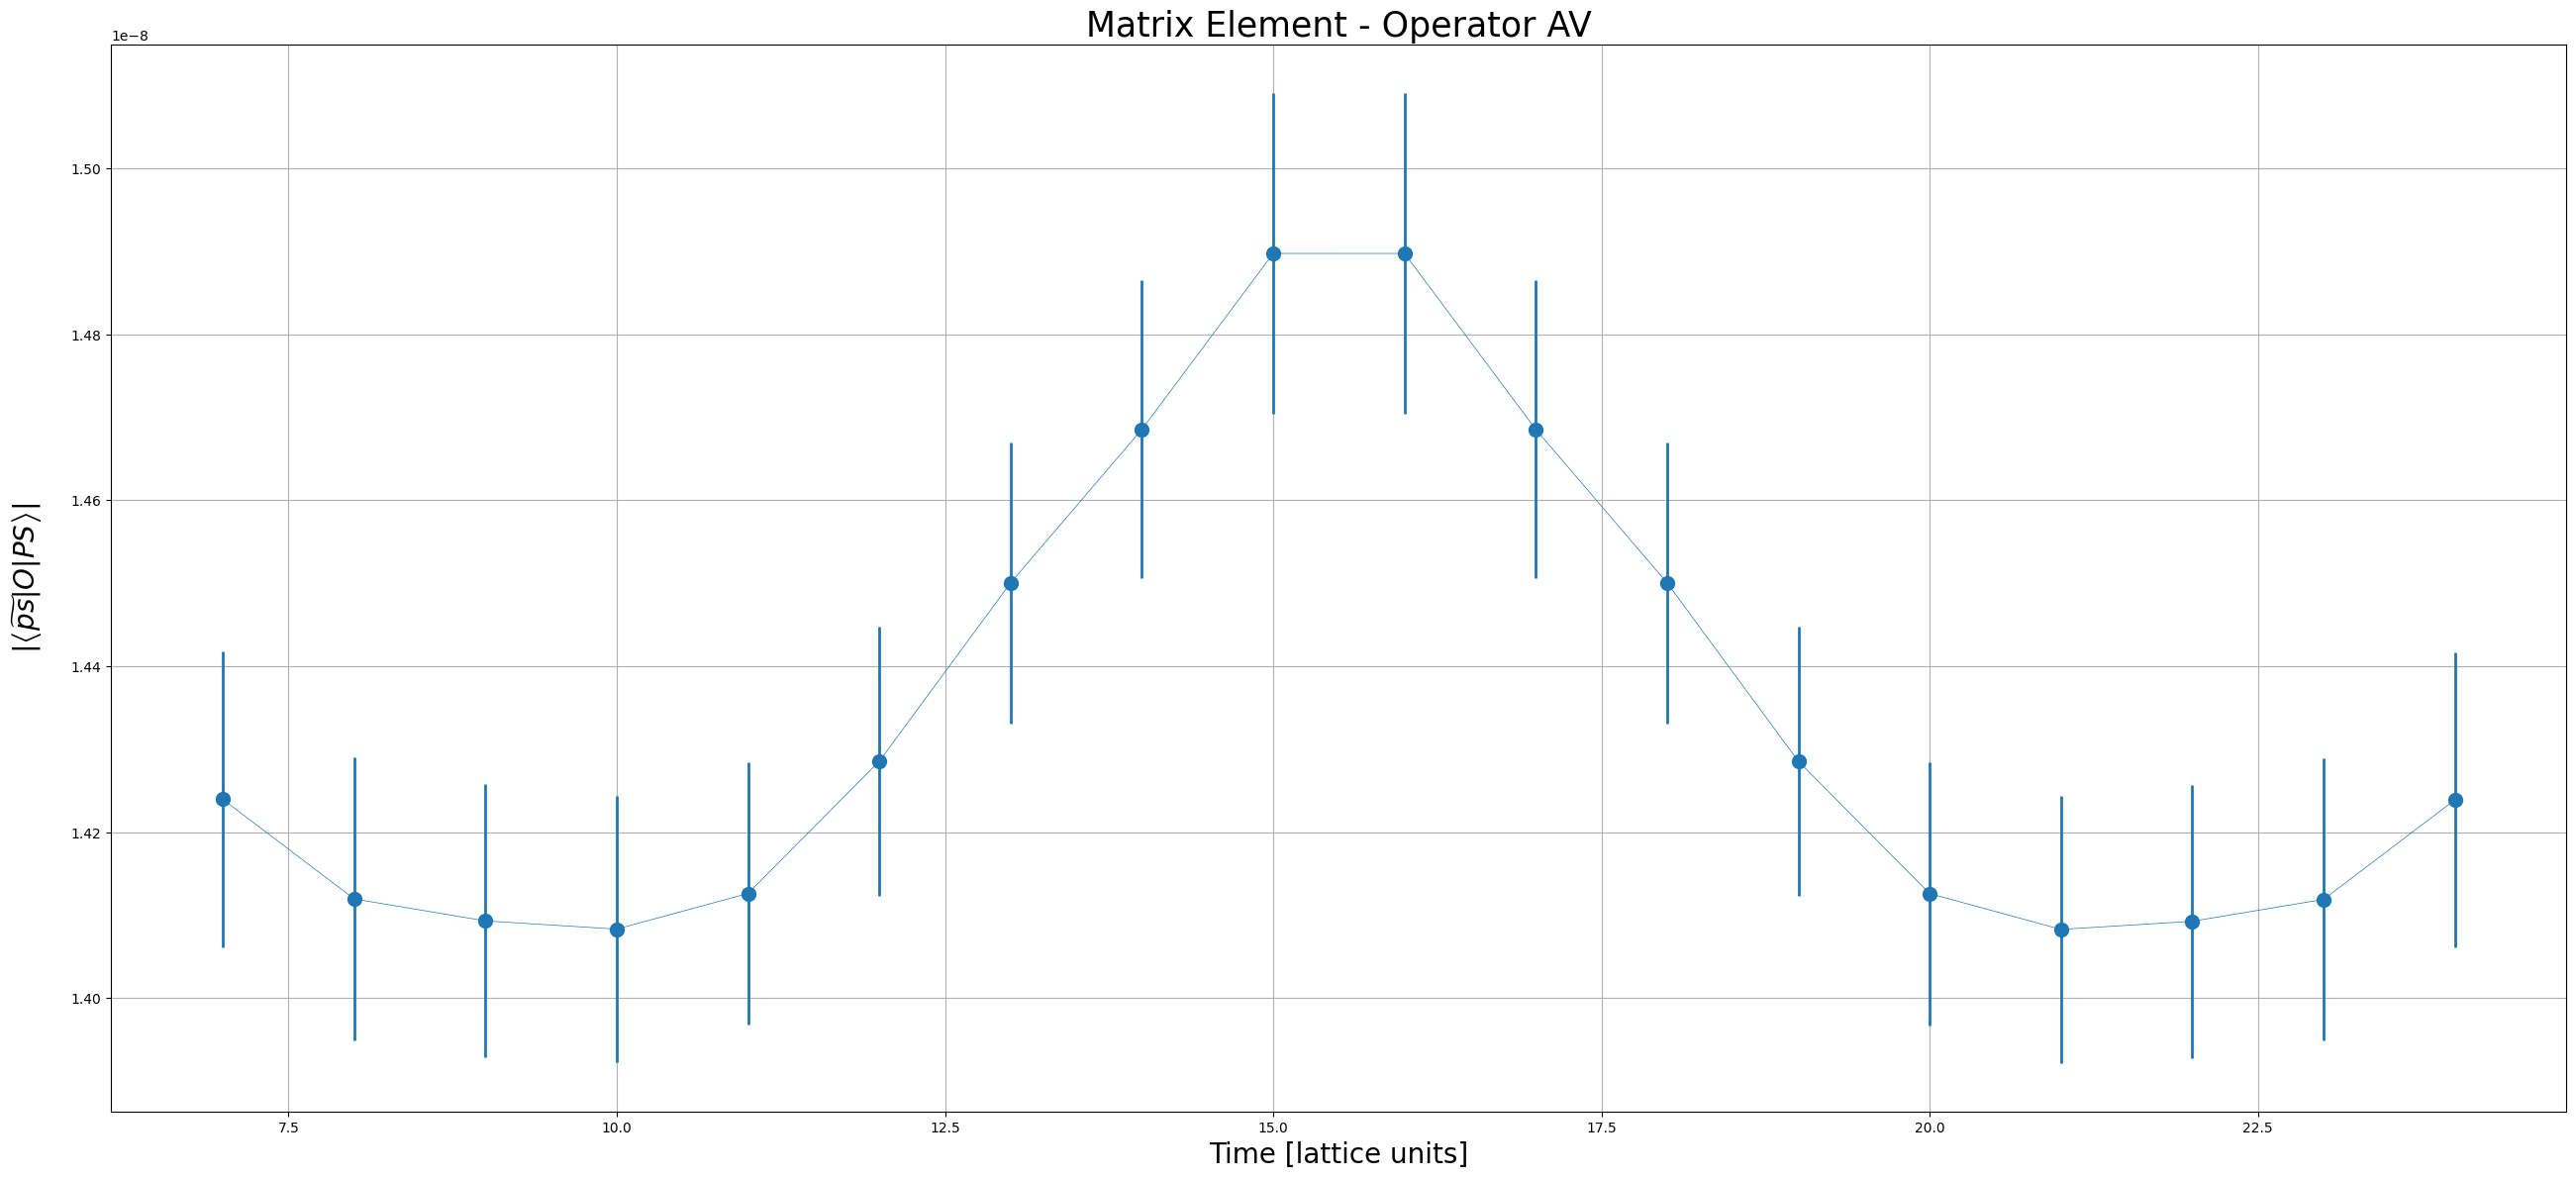

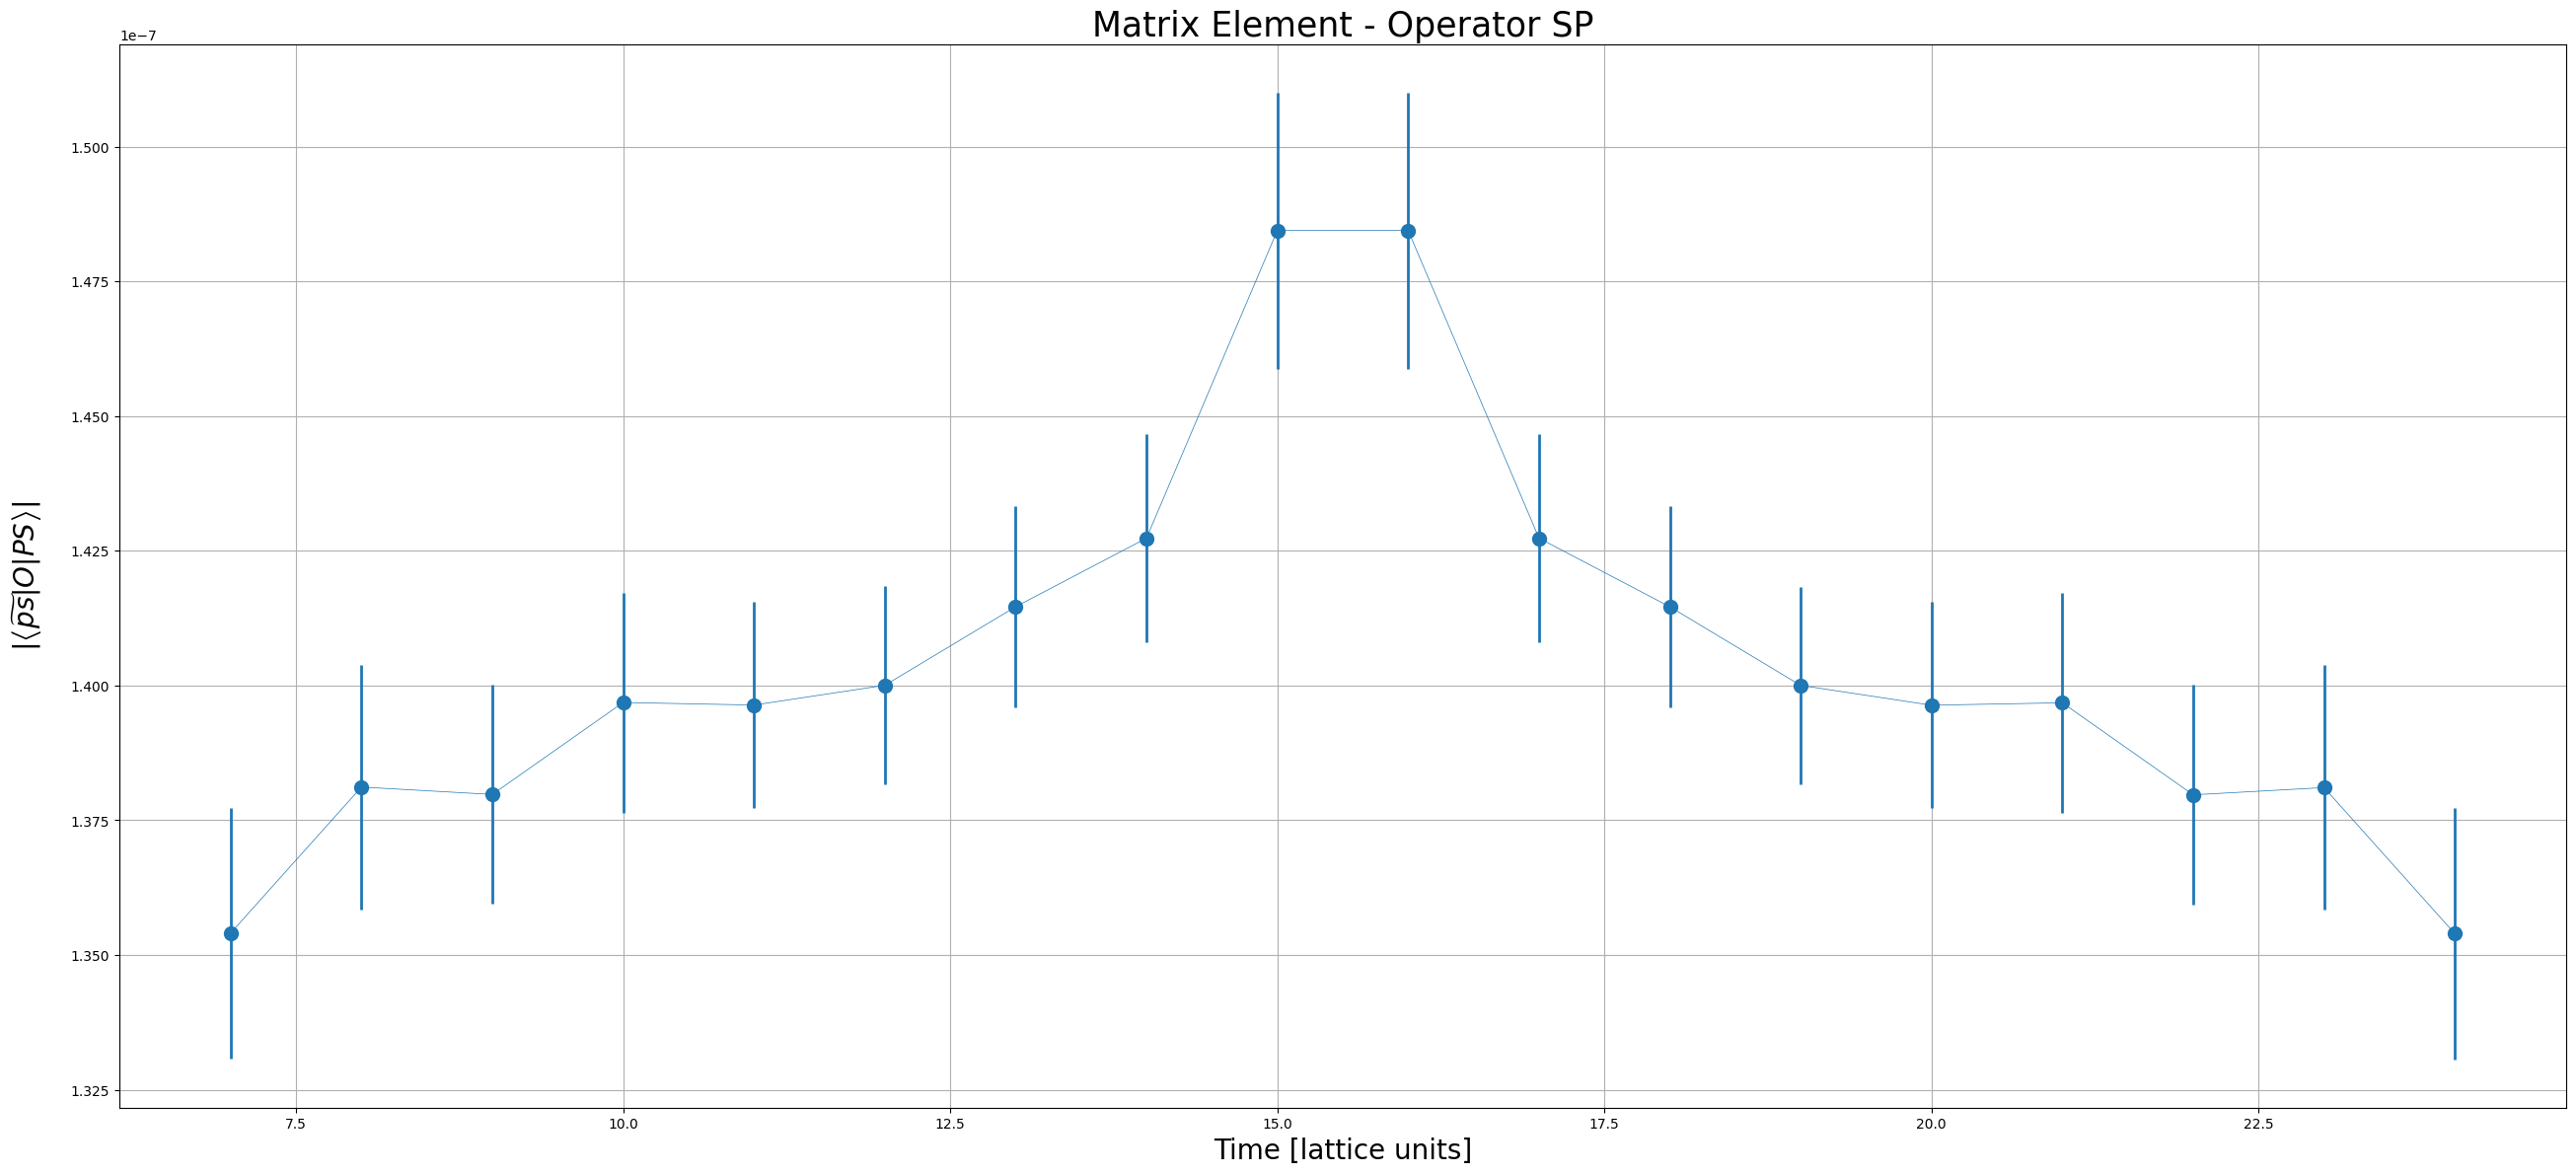

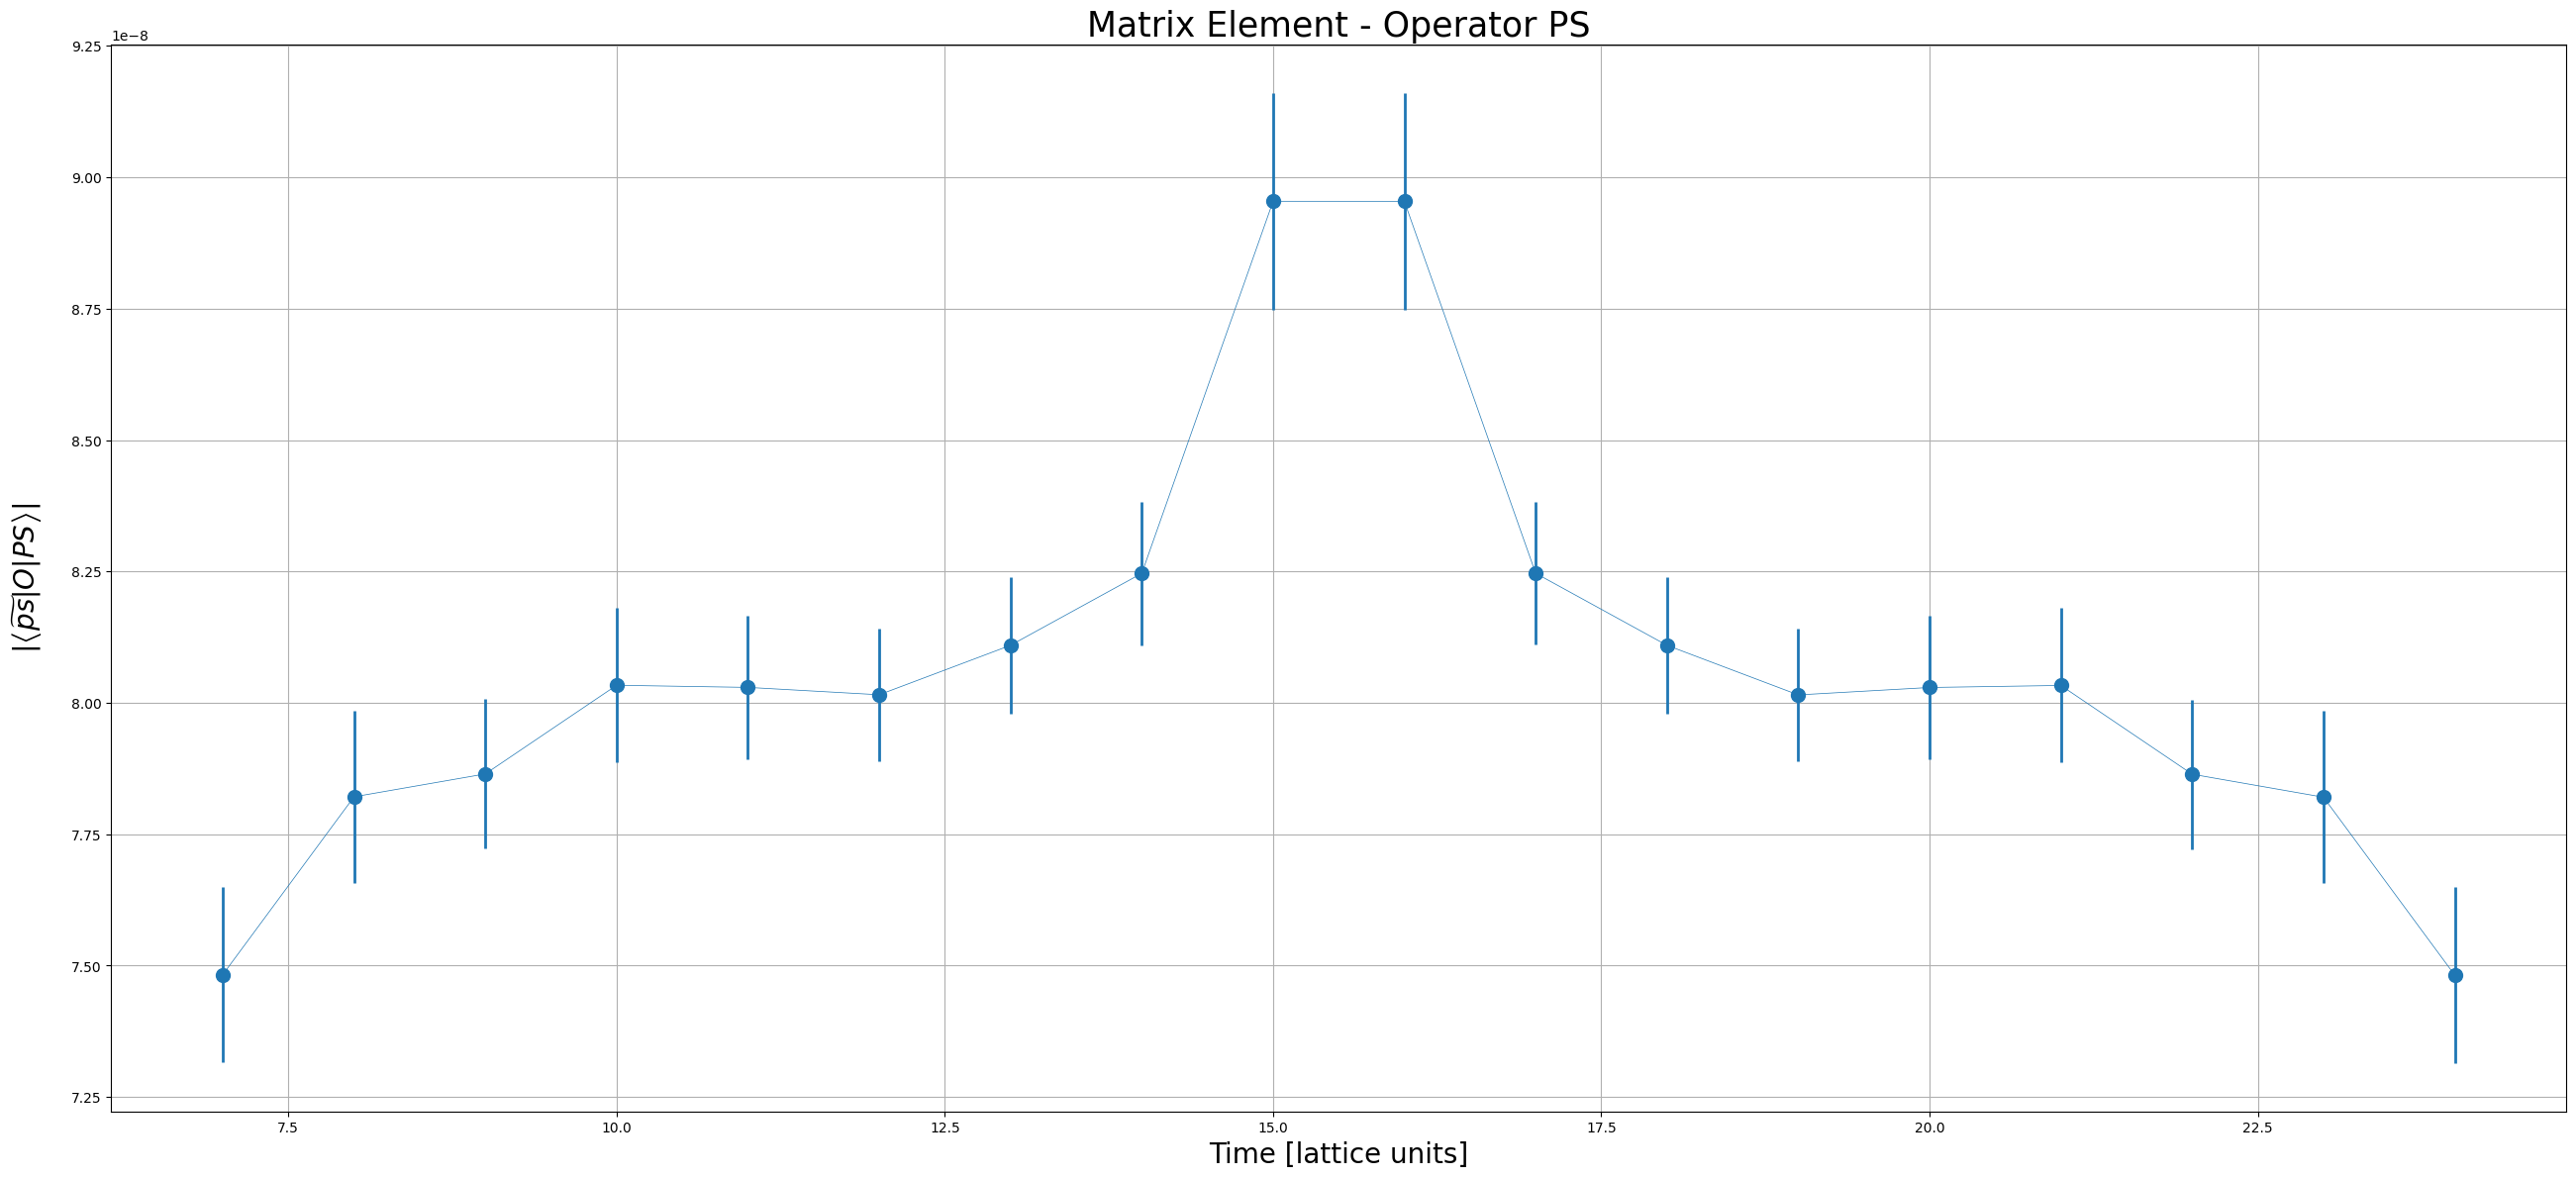

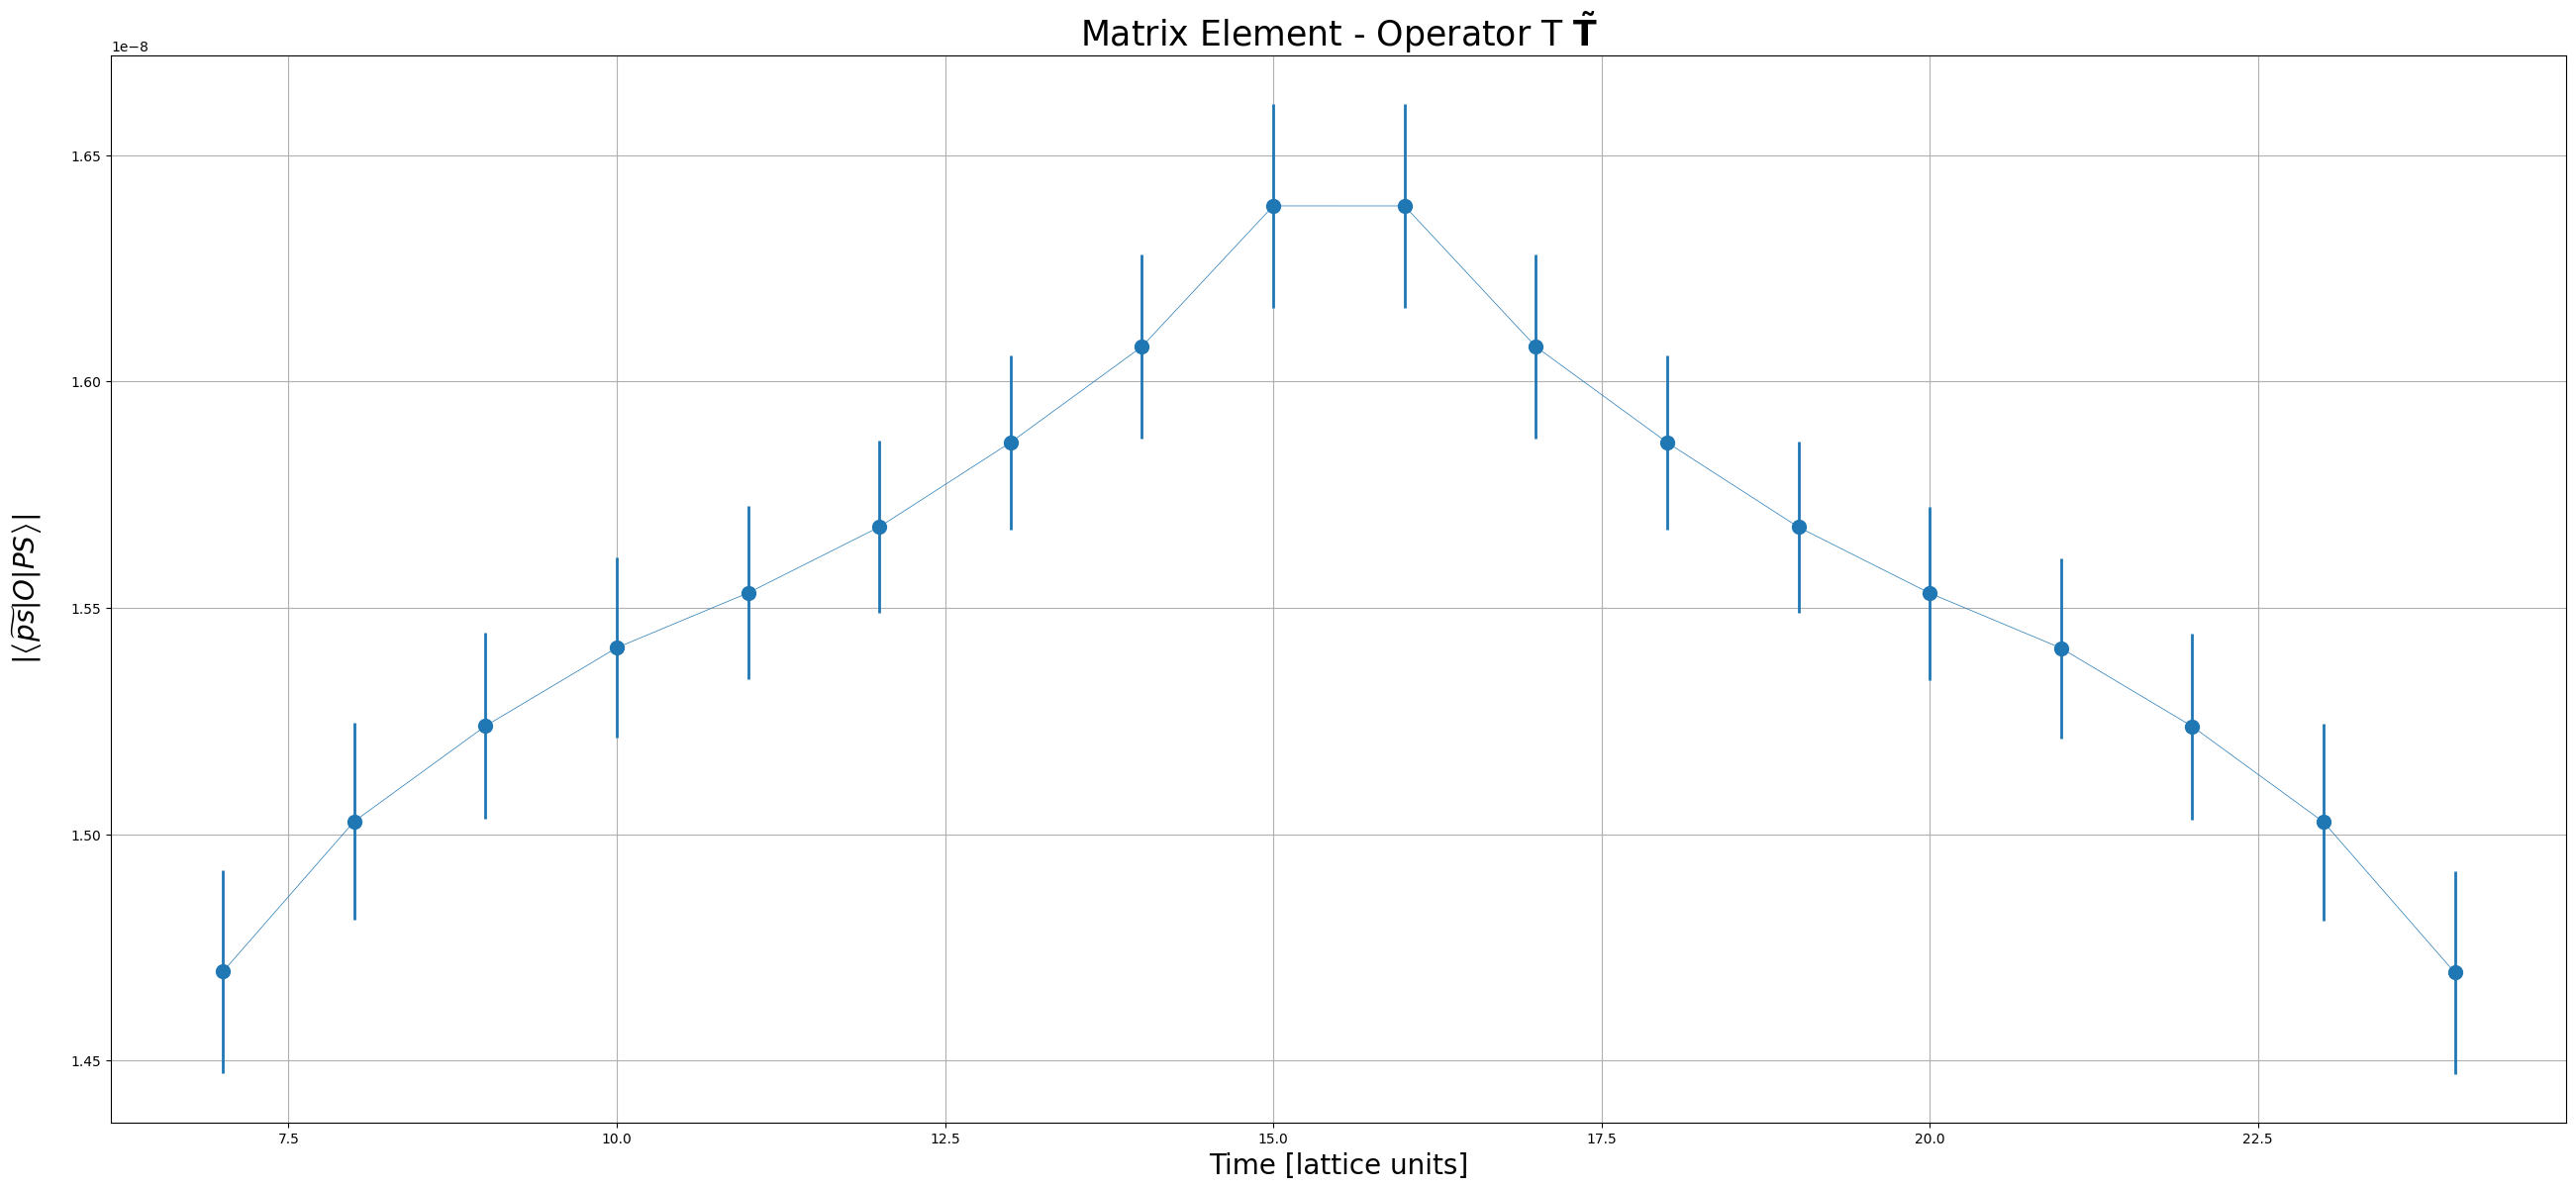

In [31]:
#times on x axis
times = np.arange(0,tvals)

cut=7

op_names = ["VA","AV","SP","PS",r'T $\mathbf{\~{T}}$']
op_names_txt = ["VA","AV","SP","PS",'TTtilda']

#create figure and axis

for iop in range(noperators):
    _= plt.figure(figsize=(32, 14))
    _=plt.errorbar(times[cut:-cut],mat_ele_jack[iop,cut:-cut],yerr=mat_ele_jack_std[iop,cut:-cut],marker='o',linestyle='solid',markersize=10,linewidth=0.5,elinewidth=2)
    plt.grid()
    _=plt.title(f"Matrix Element - Operator {op_names[iop]}",fontsize=25)
    _=plt.ylabel(r'$\left|\left<\widetilde{ps}|O|PS\right>\right|$',rotation=90,labelpad=20,fontsize=20)
    _=plt.xlabel('Time [lattice units]',fontsize=20)
    plt.savefig(f'matrix_element_first_analysis/matrix_element_{op_names_txt[iop]}.png')
    #plt.close()


## jack first

In [176]:
#jackknife
test_statistic = np.mean

corr_x_navg_jack = np.empty(shape=(tvals),dtype=float)
corr_x_navg_jack_std = np.empty(shape=(tvals),dtype=float)
corr_z_navg_jack = np.empty(shape=(tvals),dtype=float)
corr_z_navg_jack_std = np.empty(shape=(tvals),dtype=float)
corr_3p_navg_jack = np.empty(shape=(noperators,tvals),dtype=float)
corr_3p_navg_jack_std = np.empty(shape=(noperators,tvals),dtype=float)


for t in range(tvals):

    data = corr_x_navg[:,t].real

    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    corr_x_navg_jack[t] = estimate
    corr_x_navg_jack_std[t] = stderr

    if np.abs(bias/estimate)>10**-10:
        print(f"x / {t} / {bias}")



    data = corr_z_navg[:,t].real

    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    corr_z_navg_jack[t] = estimate
    corr_z_navg_jack_std[t] = stderr

    if np.abs(bias/estimate)>10**-10:
        print(f"z / {t} / {bias}")

    for iop in range(noperators):

        data = corr_3p_navg[:,iop,t].imag

        estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

        corr_3p_navg_jack[iop,t] = estimate
        corr_3p_navg_jack_std[iop,t] = stderr

        if np.abs(bias/estimate)>10**-10:
            print(f"3p / {iop} / {t} / {bias}")



if verbose:
    print("(tvals)")
    print(np.shape(corr_x_navg_jack))
    print(np.shape(corr_z_navg_jack))
    print("(noperators,tvals)")
    print(np.shape(corr_3p_navg_jack))

/tmp/ipykernel_5742/851436603.py:21: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(bias/estimate)>10**-10:
/tmp/ipykernel_5742/851436603.py:33: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(bias/estimate)>10**-10:
/tmp/ipykernel_5742/851436603.py:45: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(bias/estimate)>10**-10:


(tvals)
(32,)
(32,)
(noperators,tvals)
(5, 32)


In [177]:
mat_ele_squared_afterjack = np.empty(shape=(noperators,tvals),dtype=float)

for iop in range(noperators):
    for t in range(tvals):
        mat_ele_squared_afterjack[iop,t] = corr_3p_navg_jack[iop,t] * ( - corr_3p_navg_jack[iop,tvals-1-t] ) / ( corr_z_navg_jack[1] * corr_x_navg_jack[tvals-2] )

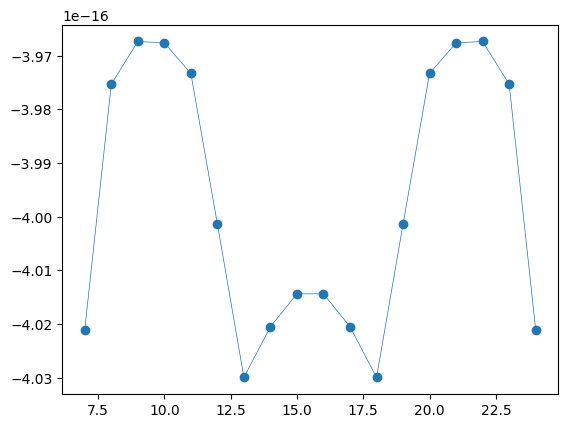

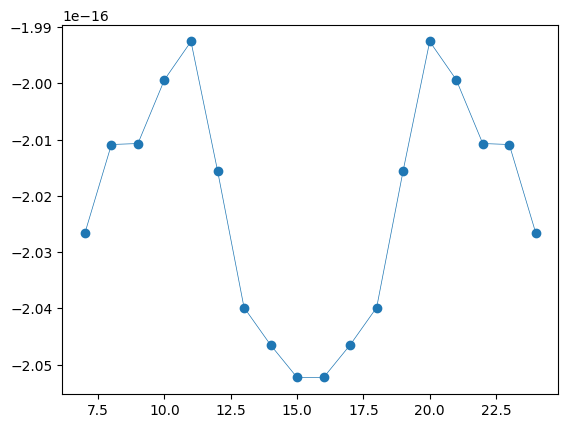

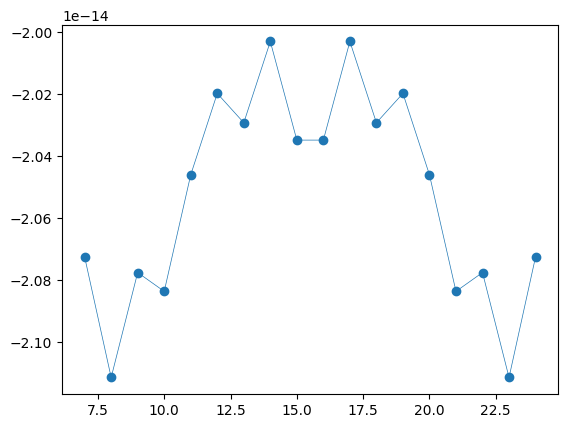

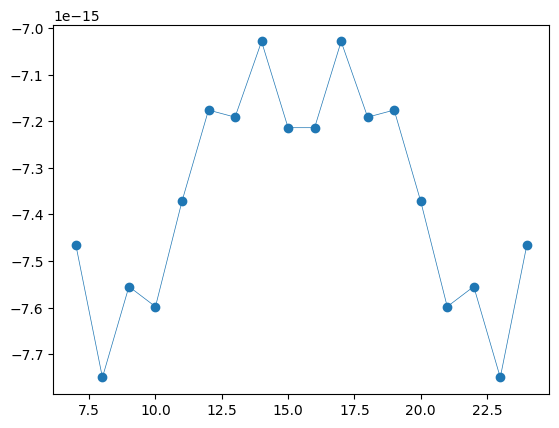

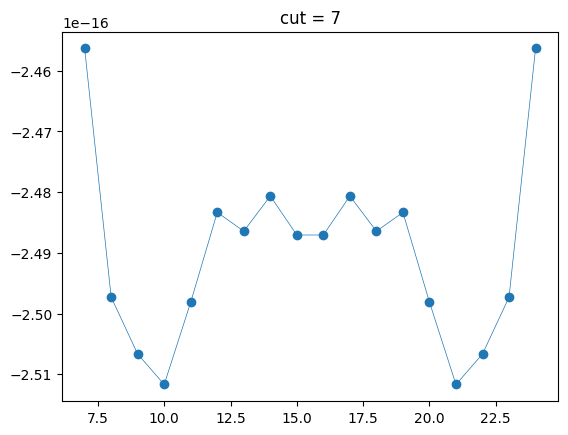

In [178]:
times = np.arange(tvals)
cut = 7

for iop in range(noperators):
    _ = plt.figure()
    _ = plt.plot(times[cut:-cut],mat_ele_squared_afterjack[iop,cut:-cut],'-o',linewidth=0.5)
    #_ = plt.errorbar(times[cut:-cut],mat_ele_squared_afterjack[iop,cut:-cut],yerr=mat_ele_squared_jack_std[iop,cut:-cut],marker='o',linewidth=0.7)

_ = plt.title(f"cut = {cut}")